Join dataset into a single file while adding "Reboot" column

In [ ]:
'''
import os
import zipfile
import pandas as pd

zip_filename = "AndMal2020-Dynamic-BeforeAndAfterReboot.zip"
extract_folder = "Extracted_Files"

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

csv_files = [os.path.join(root, file)
             for root, _, files in os.walk(extract_folder)
             for file in files if file.endswith(".csv")]

df_list = []

for csv_file in csv_files:
    df_temp = pd.read_csv(csv_file)

    file_name = os.path.basename(csv_file).lower()

    if "after" in file_name:
        df_temp["reboot"] = "after"
    elif "before" in file_name:
        df_temp["reboot"] = "before"
    else:
        df_temp["reboot"] = "unknown"

    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

df.to_csv("FinalDynamicDataset.csv", index=False)

print("Dataset created successfully!")
print(df["reboot"].value_counts(dropna=False))
'''

The "Reboot" column was added to our dataset to provide a clearer understanding of how malware behaves in different system states. Each category of malware is represented by two CSV files: one labeled "before_reboot" and another "after_reboot". This distinction is critical because the majority of Android malware executes harmful actions through network interactions, and these behaviors can vary significantly depending on whether the device has been rebooted. By analyzing the differences in network activity before and after a reboot, we can gain valuable insights into the malware's tactics and strategies, thereby improving our detection. This approach allows for a more comprehensive analysis of malware behavior and its impact on system security.

# 1.1 Exploratory Analysis

In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#IRINA
#file_path ="/content/drive/MyDrive/BCSAI_4SEMESTER/Machine_Learning_Foundations/FinalProject/FinalDynamicDataset.csv"
#df = pd.read_csv(file_path)

In [20]:
#FEDE
file_path ="/content/drive/MyDrive/AAASEM4/MachineLearning/FinalDynamicDataset.csv"
df = pd.read_csv(file_path)

## General info

In [21]:
df.head()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  Memory_PrivateDirty  \
0            31053             2448               14044                23472   
1           107787            21976               11852                74548   
2            86584            18460               12284                59992   
3            41248              924               10328                36280   
4            38621             5080               12392                27388   

   Memory_SharedClean  Memory_PrivateClean  Memory_SwapPssDirty  \
0               74824                 2452                    0   
1               69052                23152                    0   
2               91548                19376                    0   
3               55768                  928                    0   
4               71048                 5088                    0   

   Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  ...  Logcat_error  \
0             8919              4786             4132  ...          1635   
1            25341             20965             4375  ...          1816   
2            24500             21378             3121  ...          2244   
3            10082              7281             2800  ...           974   
4             9077              5750             3326  ...           936   

   Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  Process_total  \
0            2351          3285            1551         11221            193   
1             826          1544            2045          8457            189   
2            3406          1565            2819         10780            195   
3            4134          3138            1556         11739            191   
4            2298          3752            1992         10488            188   

                                                Hash    Category    Family  \
0  f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...  Trojan_SMS    opfake   
1  556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...  Trojan_SMS    opfake   
2  398322f94b5bfa2a9e7b3756a4cf409764595003280c48...  Trojan_SMS  fakeinst   
3  4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...  Trojan_SMS  fakeinst   
4  6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...  Trojan_SMS  fakeinst   

   reboot  
0  before  
1  before  
2  before  
3  before  
4  before  

[5 rows x 145 columns]

In [24]:
#Dataset size
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 53439 rows and 145 columns.


In [ ]:
#Column Names
print("\nColumn Names:")
print(df.columns.tolist())


Column Names:
['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_ParcelCount', 'Memory_DeathRecipients', 'Memory_OpenSSLSockets', 'Memory_WebViews', 'API_Process_android.os.Process_start', 'API_Process_android.app.ActivityManager_killBackgroundProcesses', 'API_Process_android.os.Process_killProcess', 'API_Command_java.lang.Runtime_exec', 'API_Command_java.lang.ProcessBuilder_start', 'API_JavaNativeInterface_java.lang.Runtime_loadLibrary', 'API_JavaNativeInterface_java.lang.Runtime_load', 'API_WebView_android.webkit.WebView_loadUrl', 'API_WebView_android.webkit.WebView_loadData', 'API_WebView_android.webkit.WebView_loadDataWithBaseUR

In [ ]:
#Data Types
print("\nData Types:")
print(df.dtypes.value_counts())


Data Types:
int64     141
object      3
Name: count, dtype: int64


In [ ]:
#General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53439 entries, 0 to 53438
Columns: 144 entries, Memory_PssTotal to Family
dtypes: int64(141), object(3)
memory usage: 58.7+ MB


##Histograms


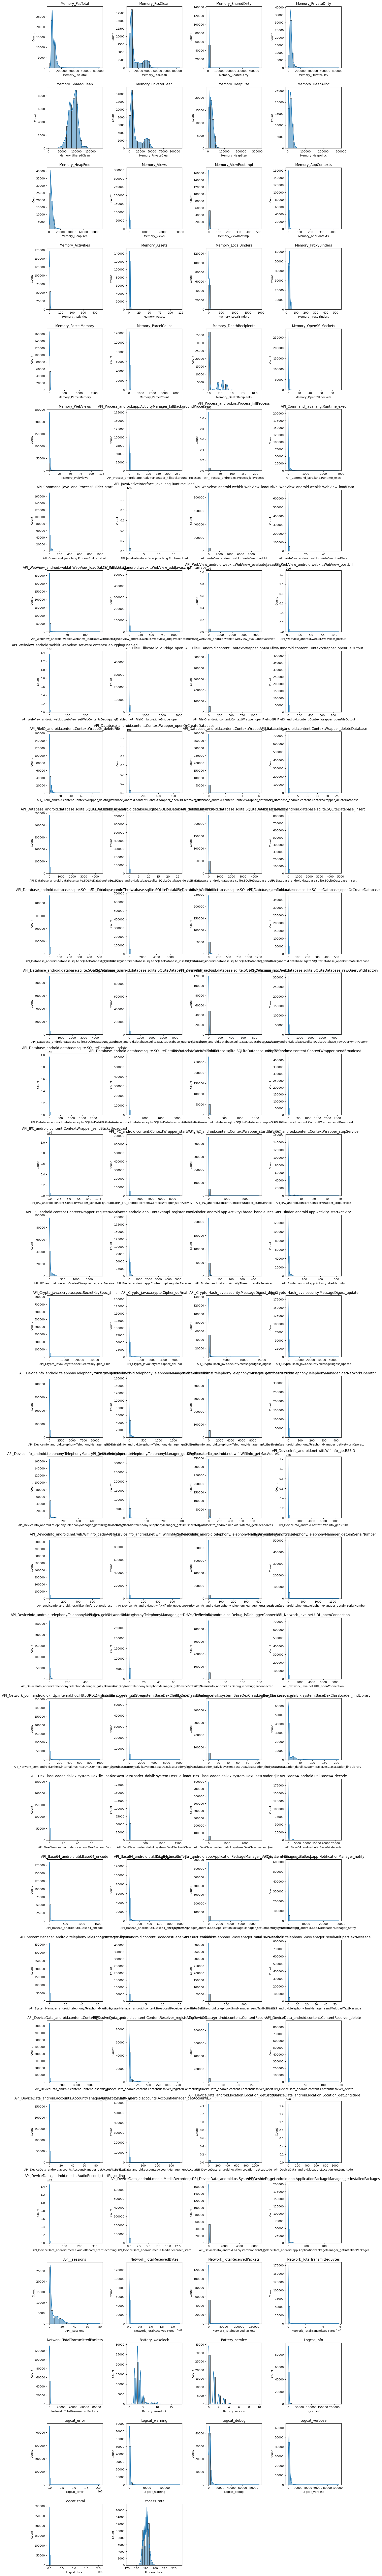

In [51]:
#Histograms
import math

# Select only numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot histograms
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

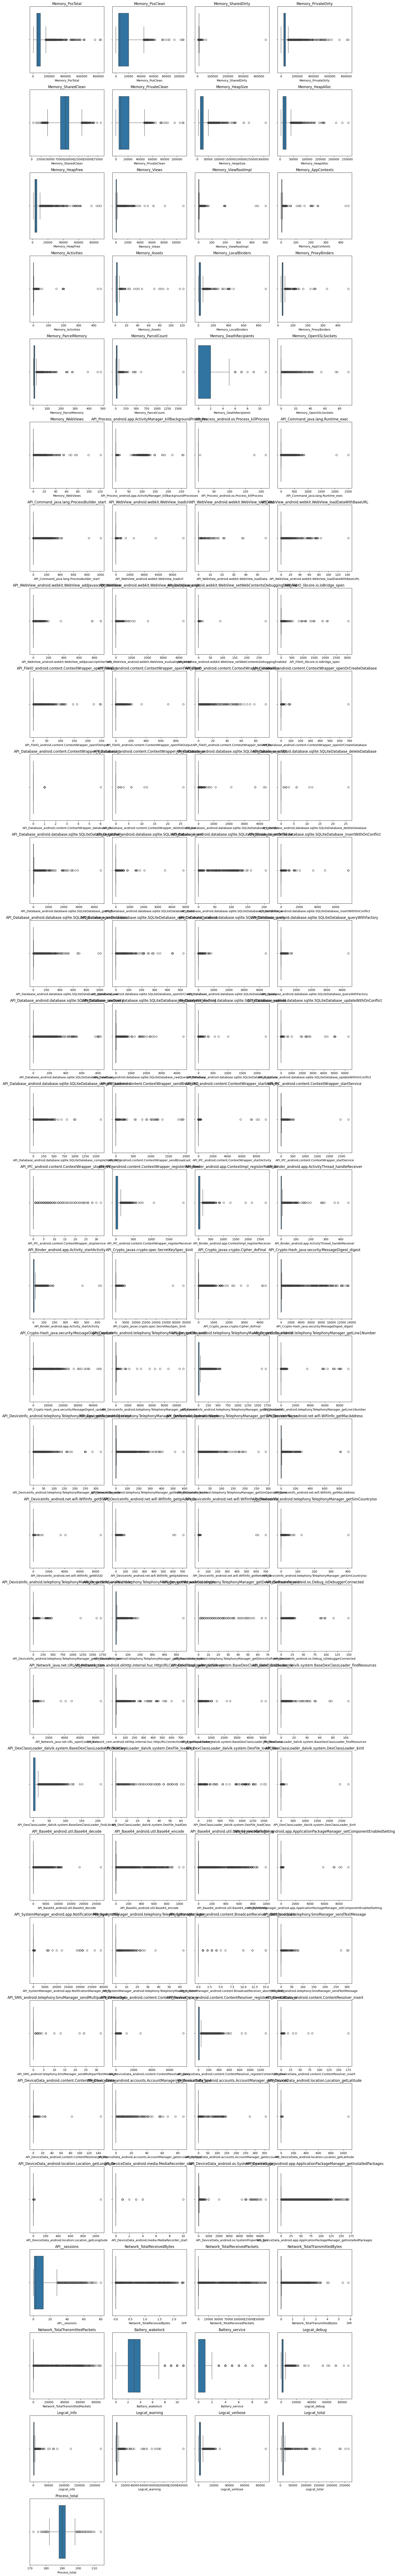

In [ ]:
#Boxplots
import math

# Select only numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot boxplots
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])  # Boxplot for each feature
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Numerical Features

Seemed to be grouped by prefixes: Memory, Network, Battery, Logcat, Process y API.

According to dataset authors to capture how various malware families and categories behave at runtime, the analysis relies on six distinct sets of features obtained after executing each sample within a controlled emulated environment. These feature groups offer a comprehensive view of the malware's dynamic activity.

This categories appear before the first _ in every feature label and are defined as:


"Memory: Memory features define activities performed by malware by utilizing memory.

API: Application Programming Interface (API) features delineate the communication between two applications.

Network: Network features describe the data transmitted and received between other devices in the network. It indicates foreground and background network usage.

Battery: Battery features describe the access to battery wakelock and services by malware.

Logcat: Logcat features write log messages corresponding to a function performed by malware.

Process: Process features count the interaction of malware with total number of processes."



In [26]:
numeric_cols = df.select_dtypes(include='number').columns

# Grouping based on the first prefix before "_"
prefix_groups = defaultdict(list)

for col in numeric_cols:
    prefix = col.split("_")[0]  # Get the first word before the underscore
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n {prefix} ({len(columns)} features):")
    for col in columns:
        print(f"  - {col}")


 Memory (23 features):
  - Memory_PssTotal
  - Memory_PssClean
  - Memory_SharedDirty
  - Memory_PrivateDirty
  - Memory_SharedClean
  - Memory_PrivateClean
  - Memory_SwapPssDirty
  - Memory_HeapSize
  - Memory_HeapAlloc
  - Memory_HeapFree
  - Memory_Views
  - Memory_ViewRootImpl
  - Memory_AppContexts
  - Memory_Activities
  - Memory_Assets
  - Memory_AssetManagers
  - Memory_LocalBinders
  - Memory_ProxyBinders
  - Memory_ParcelMemory
  - Memory_ParcelCount
  - Memory_DeathRecipients
  - Memory_OpenSSLSockets
  - Memory_WebViews

 API (105 features):
  - API_Process_android.os.Process_start
  - API_Process_android.app.ActivityManager_killBackgroundProcesses
  - API_Process_android.os.Process_killProcess
  - API_Command_java.lang.Runtime_exec
  - API_Command_java.lang.ProcessBuilder_start
  - API_JavaNativeInterface_java.lang.Runtime_loadLibrary
  - API_JavaNativeInterface_java.lang.Runtime_load
  - API_WebView_android.webkit.WebView_loadUrl
  - API_WebView_android.webkit.WebView_l

##Categorical Features

In [8]:
#Statistical summary for categorical features
df.describe(include=["object", "category", "bool"])

Hash  Category  Family
count                                               53439     53439   53439
unique                                              33426        14    3078
top     da9f3ac7df2f0cddf8b7cc190567f0943626d545eb25bc...  Riskware  smsreg
freq                                                    5     14053    8112

In [25]:
print(df[['Hash', 'Category', 'Family']].head())

                                                Hash    Category    Family
0  f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...  Trojan_SMS    opfake
1  556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...  Trojan_SMS    opfake
2  398322f94b5bfa2a9e7b3756a4cf409764595003280c48...  Trojan_SMS  fakeinst
3  4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...  Trojan_SMS  fakeinst
4  6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...  Trojan_SMS  fakeinst


Hash: unique identifier that represents each malware sample.

Category: general classification of the malware sample based on its behavior.

Family: more fine-grained grouping of malware based on its codebase or origin

For hash, it will first be checked if the same malware before and after reboot contains the same hash value.

In [39]:
# Count how many times each hash appears in 'before' and 'after'
hash_reboot_counts = df.groupby(['Hash', 'reboot']).size().unstack(fill_value=0)

# Hashes in both with exactly one in each
hashes_with_one_each = hash_reboot_counts[
    (hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1)
].index

# Hashes in both but with extra rows
hashes_in_both_but_not_clean = hash_reboot_counts[
    (hash_reboot_counts['before'] > 0) &
    (hash_reboot_counts['after'] > 0) &
    ~((hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1))
].index

# Total unique hashes
total_unique_hashes = df['Hash'].nunique()

# Hashes in only one reboot condition
hashes_in_one_condition = hash_reboot_counts[
    (hash_reboot_counts['before'] == 0) | (hash_reboot_counts['after'] == 0)
]

# Only once in one reboot condition
only_once_in_one = hashes_in_one_condition[
    (hashes_in_one_condition['before'] == 1) | (hashes_in_one_condition['after'] == 1)
]

# More than once in one reboot condition
more_than_once_in_one = hashes_in_one_condition[
    ((hashes_in_one_condition['before'] > 1) & (hashes_in_one_condition['after'] == 0)) |
    ((hashes_in_one_condition['after'] > 1) & (hashes_in_one_condition['before'] == 0))
]

# Split those into counts
more_than_once_in_before = more_than_once_in_one[more_than_once_in_one['before'] > 1]
more_than_once_in_after = more_than_once_in_one[more_than_once_in_one['after'] > 1]

# --- PRINT RESULTS ---
print(f"Hashes with EXACTLY one row in BOTH before and after: {len(hashes_with_one_each)}")
print(f"Hashes in BOTH, BUT with extra rows: {len(hashes_in_both_but_not_clean)}")

print(f"\nHashes in ONLY ONE reboot condition:")
print(f"• Appearing ONLY ONCE: {len(only_once_in_one)}")
print(f"• Appearing MORE THAN ONCE: {len(more_than_once_in_one)}")
print(f"   - More than once in BEFORE: {len(more_than_once_in_before)}")
print(f"   - More than once in AFTER: {len(more_than_once_in_after)}")

print(f"\nTotal breakdown:")
print(f"• In BOTH (any): {len(hashes_with_one_each) + len(hashes_in_both_but_not_clean)}")
print(f"• In ONLY ONE reboot: {len(hashes_in_one_condition)}")
print(f"• TOTAL unique hashes: {total_unique_hashes}")


Hashes with EXACTLY one row in BOTH before and after: 19169
Hashes in BOTH, BUT with extra rows: 158

Hashes in ONLY ONE reboot condition:
• Appearing ONLY ONCE: 13695
• Appearing MORE THAN ONCE: 404
   - More than once in BEFORE: 404
   - More than once in AFTER: 0

Total breakdown:
• In BOTH (any): 19327
• In ONLY ONE reboot: 14099
• TOTAL unique hashes: 33426


A total of 19,169 hashes appear exactly once in both before and after conditions. These are highly reliable for paired  comparisons, ideal for understanding how reboot affects malware behavior.


There are 158 hashes that appear in both reboot states but not exactly once in each. These extra instances may come from inconsistencies in data capture like multiple logs for the same sample and should be checked.

A significant portion of samples appear only in one reboot condition. This is consistent with limitations described in the original dataset paper, where some malware samples failed to execute after the reboot. However, what is curious is that some still have been logged more than once.


In [44]:
df = df.drop(columns=['Hash'])
'''
The Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.
It serves as an identifier for each malware sample. Including this column in modeling
would not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are
sensitive to high-cardinality categorical features.
'''

'\nThe Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset. \nIt serves as an identifier for each malware sample. Including this column in modeling \nwould not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are \nsensitive to high-cardinality categorical features. \n'

This project will be using both Category and Family as the target variables for classification.

## Reboot Analysis

In [6]:
print(df["reboot"].value_counts())

reboot
before    28380
after     25059
Name: count, dtype: int64


The imbalance observed in the dataset, with 28,380 samples collected before reboot and only 25,059 after reboot, is explained by limitations found during the dynamic analysis. The authors of the dataset note that "there was no entry point in some Android malware samples and some Android malware samples stopped abruptly." This means that certain malware applications either failed to launch or terminated unexpectedly during execution, preventing the collection of dynamic behavior data, particularly after the reboot phase.

Additionally, the study highlights another critical limitation: "the dynamic analysis is performed in an emulator. Some malware samples are able to detect the emulated environment and are not executed." This behavior reflects common anti-analysis techniques used by sophisticated malware, which can detect when they are running in a sandbox or emulator and intentionally suspend their malicious actions.




In [9]:
category_reboot_dist = df.groupby('reboot')['Category'].value_counts().unstack().fillna(0)
category_reboot_dist = category_reboot_dist.T

print("Category distribution per reboot state:\n")
display(category_reboot_dist)


Category distribution per reboot state:



reboot          after  before
Category                     
Adware           5142    5838
Backdoor          546     591
FileInfector      119     129
No_Category       884    1048
PUA               625     665
Ransomware       1550    1861
Riskware         6792    7261
Scareware         424     462
Trojan           4025    4412
Trojan_Banker     123     118
Trojan_Dropper    733     837
Trojan_SMS        911    1028
Trojan_Spy       1039    1801
Zero_Day         2146    2329

The displayed features are the top 10  most affected by reboot showing a clear reboot-sensitive behavior.

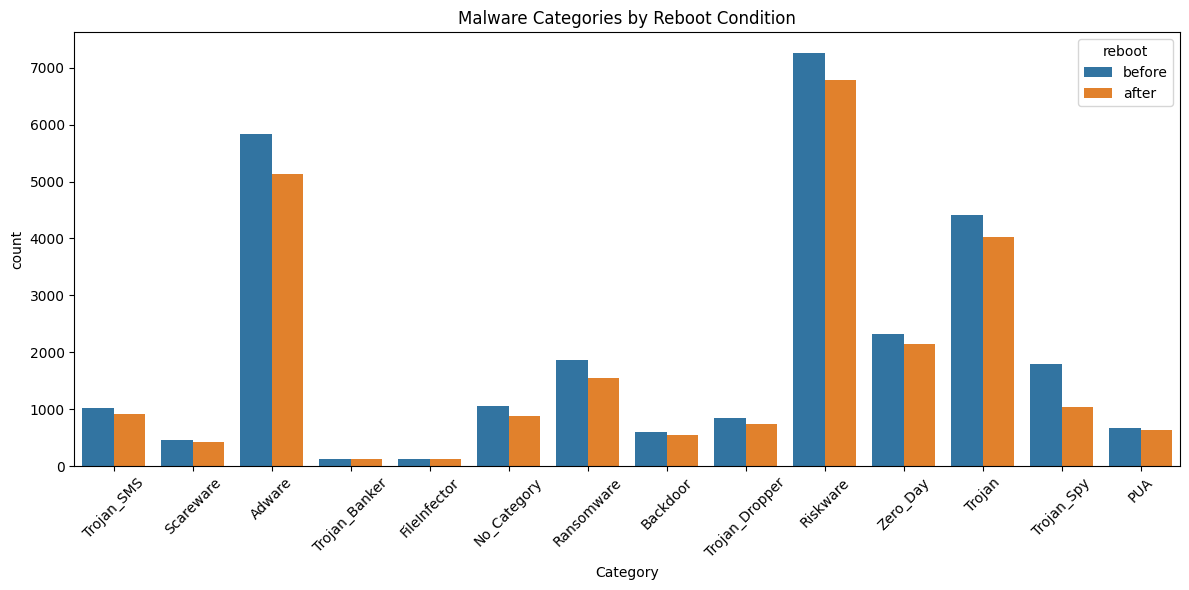

In [8]:
#Category distribution across reboot
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Category', hue='reboot')
plt.title("Malware Categories by Reboot Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


To identify which numeric features are most influenced by the reboot condition, the dataset will be grouped by the reboot variable, separating entries collected before and after the device reboot. Within each group, the mean of every numeric feature will be computed, allowing for the comparison of average behavior across both states.

A new column labeled 'diff' was then added, representing the difference between the mean values after and before the reboot for each feature. A positive value indicates that the feature increased after reboot, while a negative value shows it decreased.

In [10]:
reboot_means = df.groupby('reboot').mean(numeric_only=True).T
reboot_means['diff'] = reboot_means['after'] - reboot_means['before']
reboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)

reboot_means_sorted.head(10)

reboot                                        after        before  \
Network_TotalReceivedBytes             1.064726e+06  1.010731e+06   
Memory_SharedClean                     9.197948e+04  8.445062e+04   
Network_TotalTransmittedBytes          3.212833e+04  3.068837e+04   
Memory_HeapSize                        2.246240e+04  2.211749e+04   
Memory_HeapAlloc                       1.769606e+04  1.740553e+04   
Memory_PrivateClean                    1.438378e+04  1.425724e+04   
Memory_PrivateDirty                    4.766433e+04  4.760709e+04   
Memory_HeapFree                        4.765345e+03  4.710971e+03   
API_Base64_android.util.Base64_decode  2.266345e+02  1.784744e+02   
Network_TotalReceivedPackets           8.214127e+02  7.823693e+02   

reboot                                         diff  
Network_TotalReceivedBytes             53995.332815  
Memory_SharedClean                      7528.856824  
Network_TotalTransmittedBytes           1439.967512  
Memory_HeapSize                          344.902678  
Memory_HeapAlloc                         290.528862  
Memory_PrivateClean                      126.536769  
Memory_PrivateDirty                       57.248200  
Memory_HeapFree                           54.373837  
API_Base64_android.util.Base64_decode     48.160124  
Network_TotalReceivedPackets              39.043392

The results reveal that several features show clear shifts after reboot. Specially, network-related features such as Network_TotalReceivedBytes and Network_TotalTransmittedBytes demonstrate significant increases, suggesting that some malware types intensify data transmission once the device has rebooted. Memory features like Memory_SharedClean, Memory_HeapSize, and Memory_HeapAlloc also show increased values after reboot, indicating greater memory use or altered memory management after reboot.
This shows that the reboot condition plays an important role in runtime behavior and should be treated as an important factor in exploratory analysis and modeling.

## Missing Values

In [ ]:
#AGREGAR LO DE NO_CATEGORY

In [ ]:
#Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False))


Missing Values:
Memory_PssTotal        0
Memory_PssClean        0
Memory_SharedDirty     0
Memory_PrivateDirty    0
Memory_SharedClean     0
                      ..
Logcat_total           0
Process_total          0
Hash                   0
Category               0
Family                 0
Length: 144, dtype: int64


In [ ]:
print("Any missing values in the DataFrame:", df.isnull().values.any())

Any missing values in the DataFrame: False


Although the dataset does not contain null values, this does not necessarily mean it is free of missing information. Placeholders are commonly used in place of missing, uncollected, or undetected values. These placeholders may take the form of strings like "<unknown>", "unknown", "UNK", or values such as "0", "-1", or "none" Despite they are not technically null they still represent incomplete data.

This hidden labels can have implications for data quality and model performance. If not properly identified and handled, these placeholder values can introduce noise or skew statistical summaries.

For textual placeholders:

In [12]:
placeholders = ["<unknown>", "unknown", "UNKNOWN", "UNK", "?", "NA", "N/A", "-1", "0", "none", "null", "NULL"]

for value in placeholders:
    print(f"\nOccurrences of '{value}':")
    print((df == value).sum().sort_values(ascending=False))


Occurrences of '<unknown>':
Family                 1817
Memory_PssClean           0
Memory_SharedDirty        0
Memory_PrivateDirty       0
Memory_SharedClean        0
                       ... 
Logcat_verbose            0
Process_total             0
Hash                      0
Category                  0
reboot                    0
Length: 145, dtype: int64

Occurrences of 'unknown':
Memory_PssTotal        0
Memory_PssClean        0
Memory_SharedDirty     0
Memory_PrivateDirty    0
Memory_SharedClean     0
                      ..
Process_total          0
Hash                   0
Category               0
Family                 0
reboot                 0
Length: 145, dtype: int64

Occurrences of 'UNKNOWN':
Memory_PssTotal        0
Memory_PssClean        0
Memory_SharedDirty     0
Memory_PrivateDirty    0
Memory_SharedClean     0
                      ..
Process_total          0
Hash                   0
Category               0
Family                 0
reboot                 0
Length:

In [13]:
placeholders = ["<unknown>", "unknown", "UNK", "?", "NA", "N/A", "none", "null", "NULL"]

for value in placeholders:
    counts = (df == value).sum()

    filtered = counts[counts > 0].sort_values(ascending=False)

    if not filtered.empty:
        print(f"Occurrences of '{value}':")
        print(filtered)


Occurrences of '<unknown>':
Family    1817
dtype: int64


Family feature contains placeholder for missing values: <<xx>unknown>

For numeric placeholders:

In [15]:
numeric_placeholders = [-1, 9999, 0, 1]

for value in numeric_placeholders:
    counts = (df.select_dtypes(include="number") == value).sum()
    filtered = counts[counts > 0].sort_values(ascending=False)
    if not filtered.empty:
        print(f"\nNumeric placeholder occurrences: {value}")
        print(filtered)


Numeric placeholder occurrences: 9999
Logcat_total                     8
Memory_HeapFree                  4
Memory_HeapSize                  2
Network_TotalTransmittedBytes    2
Network_TotalReceivedBytes       1
Logcat_debug                     1
Logcat_verbose                   1
dtype: int64

Numeric placeholder occurrences: 0
Memory_AssetManagers                                     53439
Memory_SwapPssDirty                                      53439
API_WebView_android.webkit.WebView_postWebMessage        53439
API_WebView_android.webkit.WebView_savePassword          53439
API_JavaNativeInterface_java.lang.Runtime_loadLibrary    53439
                                                         ...  
API__sessions                                              727
Memory_PssClean                                            560
Battery_wakelock                                           143
Memory_PrivateClean                                          7
Memory_AppContexts                   

A large number of features contain a value of 0 in every row, indicating that they offer no variability across the dataset. This may suggest that these features were never triggered during execution or were not properly captured due to limitations in the process. Regardless of the reason, such features provide no useful information for distinguishing between different malware categories and therefore do not contribute to predictive modeling.

Check for infinity or -inifity placeholders:

In [16]:
has_inf = df.isin([np.inf, -np.inf]).any().any()
print("Contains inf:", has_inf)

Contains inf: False


In [ ]:
#Count duplicated values
df.duplicated().sum()

np.int64(0)

##Zero Standard Deviation Feature Elimination

In [ ]:
#Main statistical characteristics of the numeric columns
df.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     53439.000000     53439.000000        53439.000000   
mean      70918.399034     12742.597429        10855.112259   
std       36366.690217     12894.559046         2144.360998   
min        4506.000000         0.000000         7036.000000   
25%       46165.000000      3968.000000        10540.000000   
50%       61284.000000      6340.000000        10728.000000   
75%       91740.000000     20048.000000        11144.000000   
max      829169.000000    106360.000000       446548.000000   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         53439.000000        53439.000000         53439.000000   
mean          47633.930650        87981.107506         14316.579801   
std           29898.257374        15859.495550         13463.546087   
min              12.000000         4268.000000             0.000000   
25%           31968.000000        76642.000000          4980.000000   
50%           41432.000000        89536.000000          8176.000000   
75%           55358.000000        99052.000000         21748.000000   
max          826672.000000       183600.000000        110336.000000   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              53439.0     53439.000000      53439.000000   
mean                   0.0     22279.227231      17541.766163   
std                    0.0     12502.584219      10458.311683   
min                    0.0      5113.000000       3249.000000   
25%                    0.0     13486.500000      10669.500000   
50%                    0.0     20468.000000      16575.000000   
75%                    0.0     28735.500000      22840.000000   
max                    0.0    310155.000000     286959.000000   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     53439.000000  ...                     53439.000000   
mean       4736.468759  ...                       465.827617   
std        2920.007863  ...                      3635.819566   
min         983.000000  ...                         0.000000   
25%        2993.000000  ...                         0.000000   
50%        4068.000000  ...                        20.000000   
75%        5845.000000  ...                       123.000000   
max       88630.000000  ...                     85873.000000   

       Battery_wakelock  Battery_service  Logcat_debug    Logcat_info  \
count      53439.000000     53439.000000  53439.000000   53439.000000   
mean           3.397332         0.721215   2299.034825    2342.177717   
std            1.520636         0.981305   2053.110481    2273.059991   
min            0.000000         0.000000     40.000000       6.000000   
25%            2.000000         0.000000   1099.000000    1155.000000   
50%            3.000000         0.000000   2014.000000    2040.000000   
75%            4.000000         1.000000   3024.000000    3054.000000   
max           18.000000        10.000000  89456.000000  219143.000000   

       Logcat_warning  Logcat_error  Logcat_verbose  Logcat_total  \
count    53439.000000  5.343900e+04    53439.000000  5.343900e+04   
mean      2298.847845  2.357353e+03     2297.199629  1.159461e+04   
std       2271.006005  9.360781e+03     1971.010444  1.011978e+04   
min         36.000000  4.000000e+01       33.000000  3.121000e+03   
25%       1108.000000  1.098000e+03     1137.000000  9.417000e+03   
50%       2006.000000  2.021000e+03     2007.000000  1.097700e+04   
75%       3028.000000  3.029000e+03     3033.000000  1.298300e+04   
max     142420.000000  2.066046e+06   102860.000000  2.067038e+06   

       Process_total  
count   53439.000000  
mean      190.167181  
std         2.902841  
min       172.000000  
25%       188.000000  
50%       190.000000  
75%       192.000000  
max       226.000000  

[8 rows x 141 columns]

The chosen approach involves removing only those features with a standard deviation of exactly zero, as it means every value is identical, providing to informational value. Since the features have not yet been standardized, those with larger scales will naturally exhibit higher standard deviation. Features with zero standard deviation, such as Memory_SwapPssDirty in this dataset, can be safely discarded without any concern. This is because every value in such features is identical, resulting in no informational value.


In [22]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include='number')

# Identify columns with std = 0
zero_std_cols = numeric_cols.columns[numeric_cols.std() == 0].tolist()

print(f"Features with zero standard deviation ({len(zero_std_cols)}):")
print(zero_std_cols)

# Drop them from the dataset
df = df.drop(columns=zero_std_cols)

df.shape

Features with zero standard deviation (15):
['Memory_SwapPssDirty', 'Memory_AssetManagers', 'API_Process_android.os.Process_start', 'API_JavaNativeInterface_java.lang.Runtime_loadLibrary', 'API_WebView_android.webkit.WebView_postWebMessage', 'API_WebView_android.webkit.WebView_savePassword', 'API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword', 'API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword', 'API_Database_android.database.sqlite.SQLiteDatabase_create', 'API_DeviceInfo_android.content.pm.PackageManager_getInstallerPackageName', 'API_DeviceInfo_android.content.pm.PackageManager_getInstalledApplications', 'API_DeviceInfo_android.content.pm.PackageManager_getInstalledModules', 'API_DeviceInfo_android.content.pm.PackageManager_getInstalledPackages', 'API_Network_org.apache.http.impl.client.AbstractHttpClient_execute', 'API_Network_com.android.okhttp.internal.http.HttpURLConnectionImpl_getInputStream']


##F-test

For category:

In [47]:
# 1. Drop non-feature columns
X = df.drop(columns=["Category", "Family", "reboot"]) #Add hash if not dropped

# 2. Target
y = df["Category"]

# 3. Encode the categorical target (just for analysis)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 4. Run ANOVA F-test
f_scores, p_values = f_classif(X, y_encoded)

# 5. Create a DataFrame of results
anova_results = pd.DataFrame({
    "Feature": X.columns,
    "F_score": f_scores,
    "p_value": p_values
}).sort_values(by="F_score", ascending=False)

# 6. Display top correlated features
print("Top features most correlated with 'Category':")
print(anova_results.head(10))


Top features most correlated with 'Category':
                                               Feature     F_score  p_value
69   API_DeviceInfo_android.telephony.TelephonyMana...  907.771212      0.0
87   API_DexClassLoader_dalvik.system.BaseDexClassL...  827.839547      0.0
117                                   Battery_wakelock  790.548385      0.0
116                    Network_TotalTransmittedPackets  654.211650      0.0
101  API_DeviceData_android.content.ContentResolver...  653.378625      0.0
114                       Network_TotalReceivedPackets  641.638923      0.0
113                         Network_TotalReceivedBytes  639.445571      0.0
59   API_IPC_android.content.ContextWrapper_stopSer...  597.868641      0.0
115                      Network_TotalTransmittedBytes  532.717842      0.0
61   API_Binder_android.app.ContextImpl_registerRec...  526.056212      0.0


In [48]:
# 5. Filter features with p-value > 0.05
insignificant_features = anova_results[anova_results["p_value"] > 0.05].sort_values(by="p_value", ascending=False)

print("Features with p-value > 0.05 (low statistical significance):")
print(insignificant_features)

Features with p-value > 0.05 (low statistical significance):
                                               Feature   F_score   p_value
108  API_DeviceData_android.media.AudioRecord_start...  0.434075  0.958179
56   API_IPC_android.content.ContextWrapper_sendSti...  0.961733  0.486943
31          API_WebView_android.webkit.WebView_postUrl  1.150816  0.309853
120                                       Logcat_error  1.564845  0.087023


The above features are not statistically significant at the 95% confidence level for predicting Category. These features should be later discarded.

Top Predictive Features:

The top 10 features with highest F-score will be displayed since a high F-score indicates the feature’s values are very different between categories and consistent within each category, being very useful for prediction.

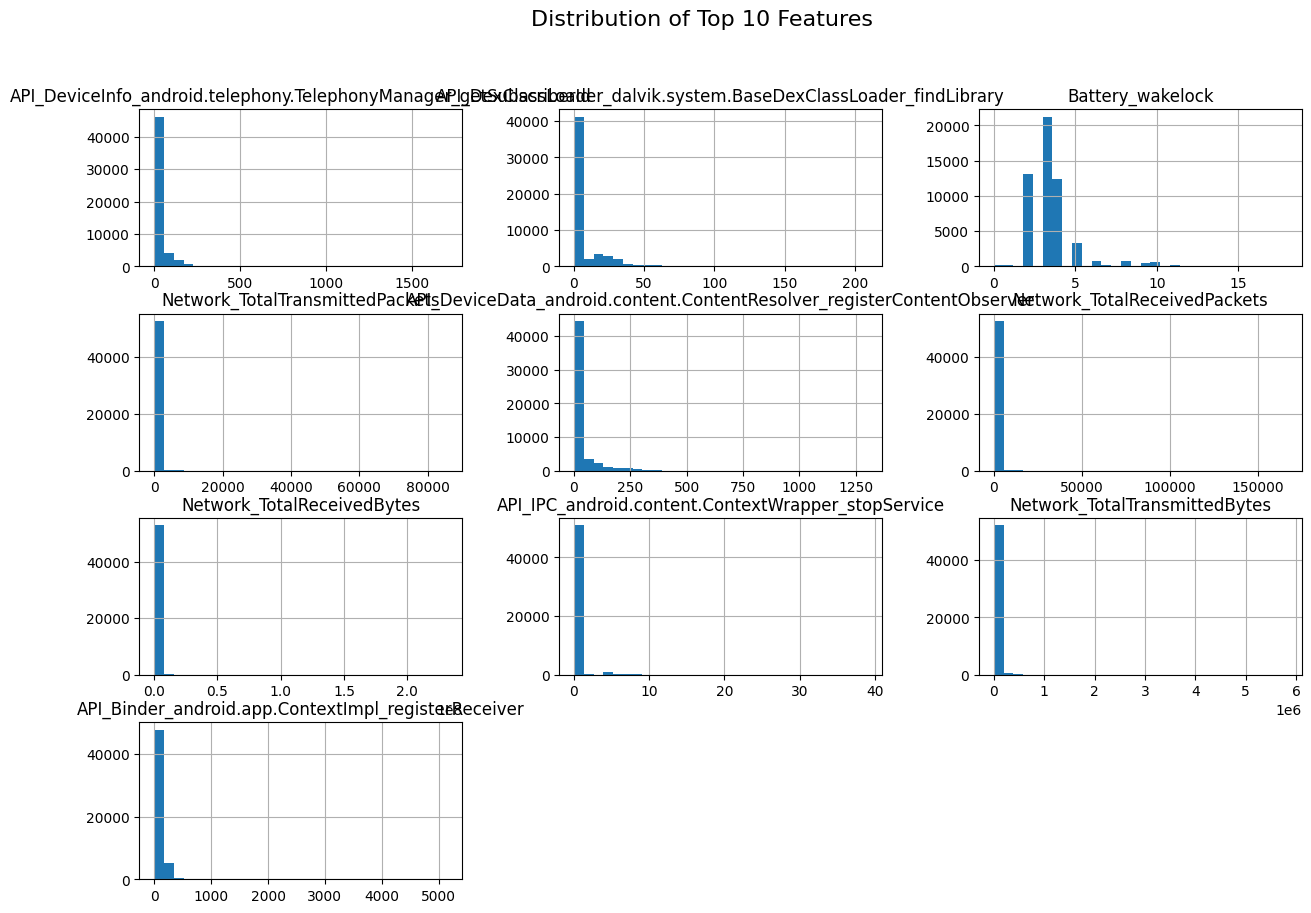

In [ ]:
top_features = anova_results.sort_values("F_score", ascending=False).head(10)["Feature"]

df[top_features].hist(figsize=(15, 10), bins=30)
plt.suptitle("Distribution of Top 10 Features", fontsize=16)
plt.show()

Most features are heavily right-skewed, having almost all values are clustered near 0.

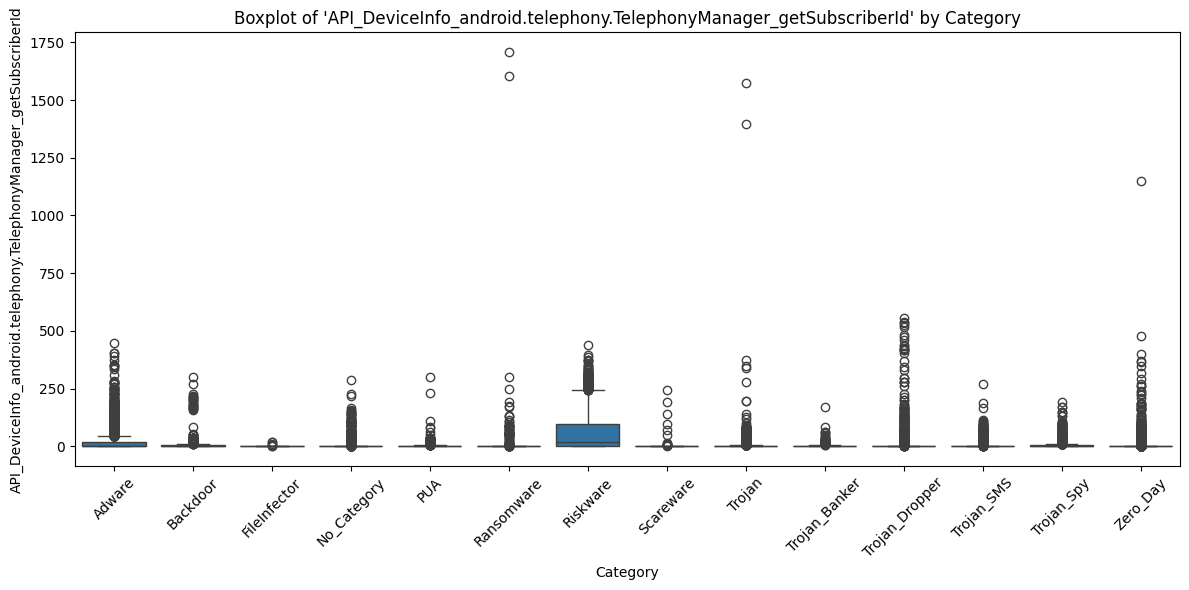

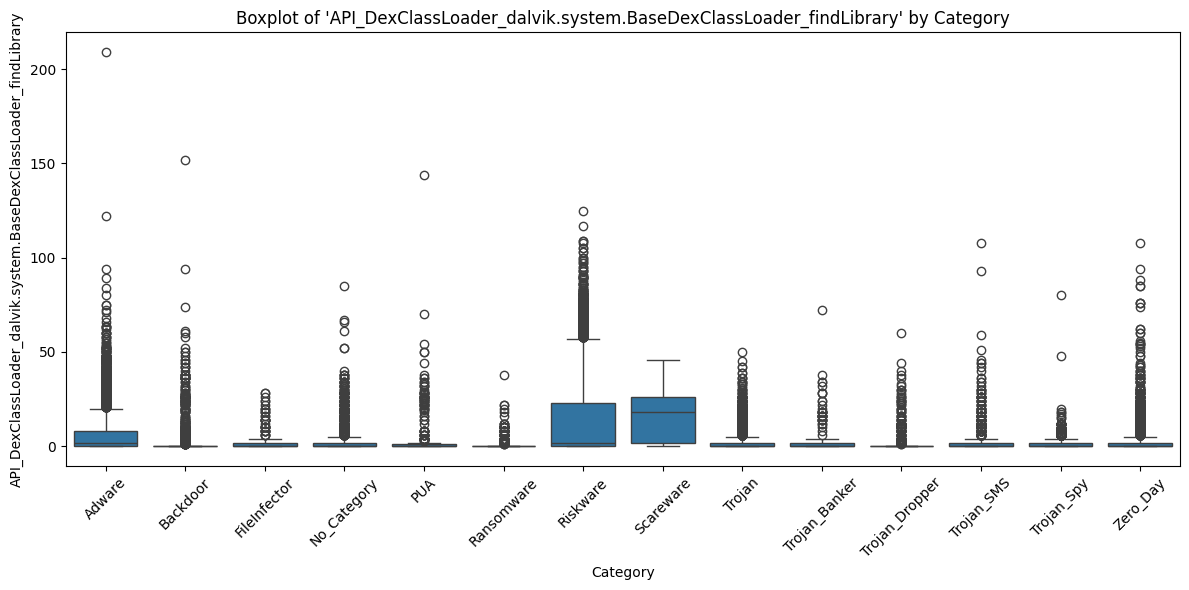

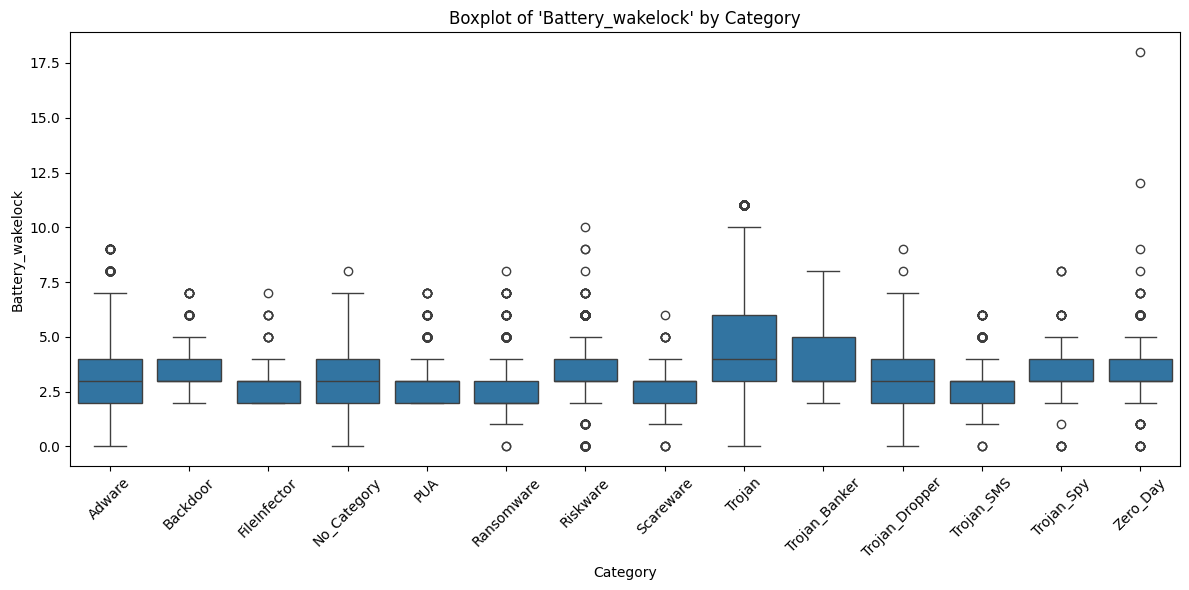

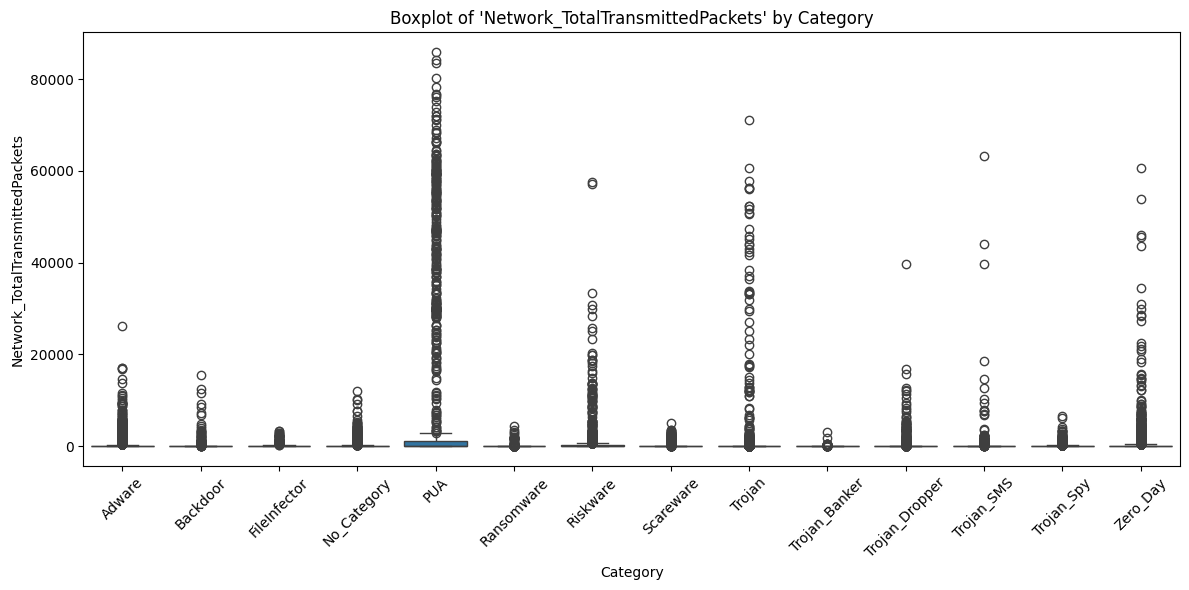

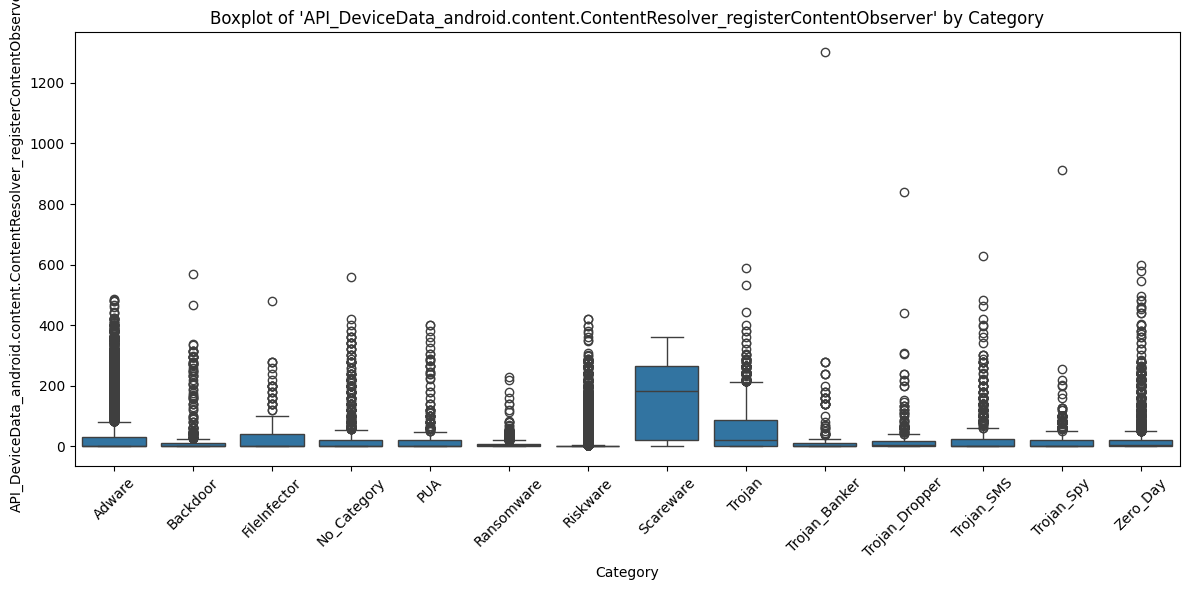

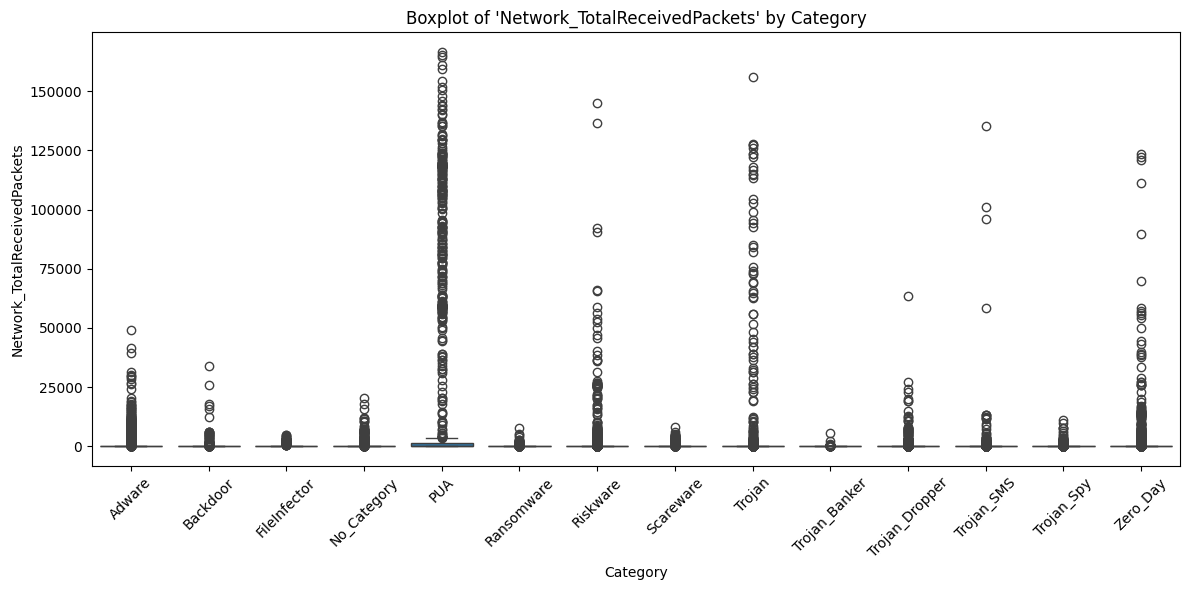

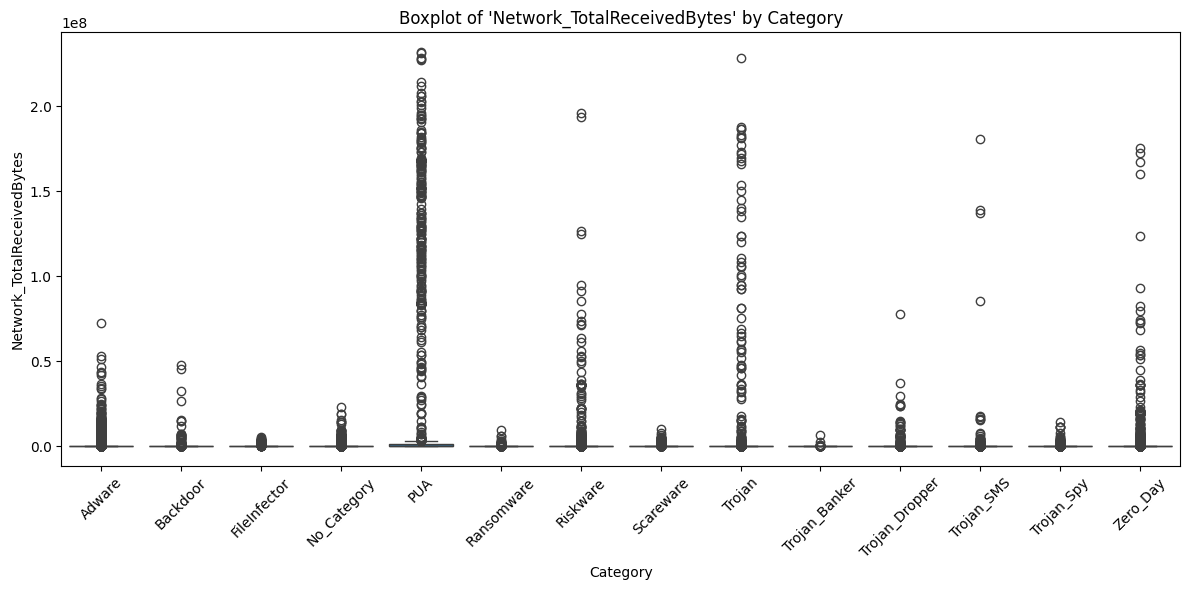

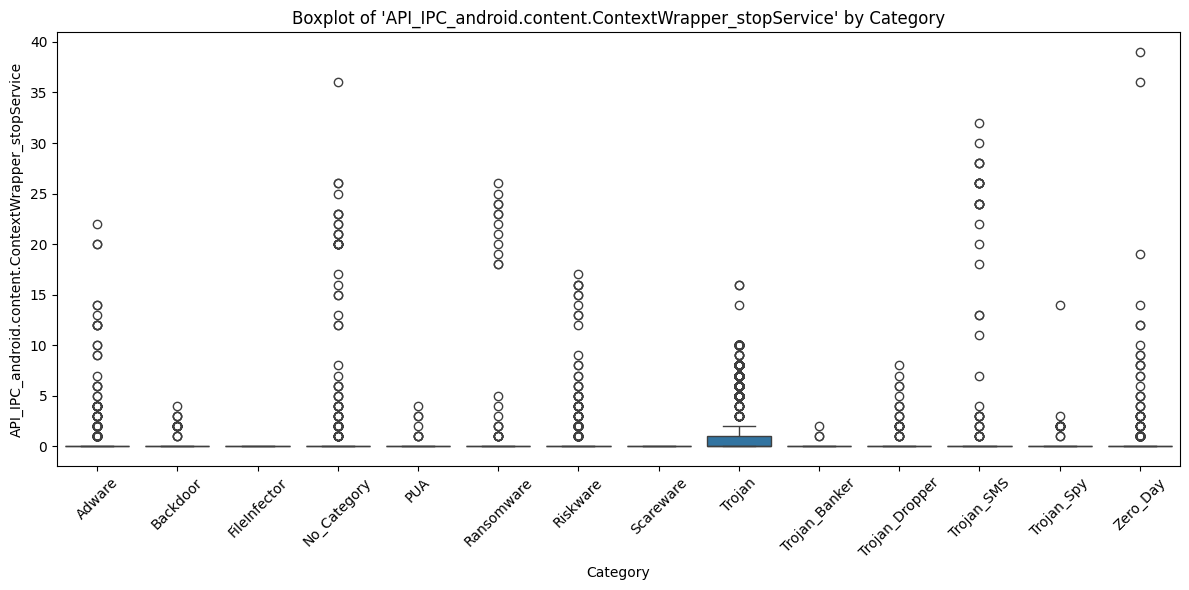

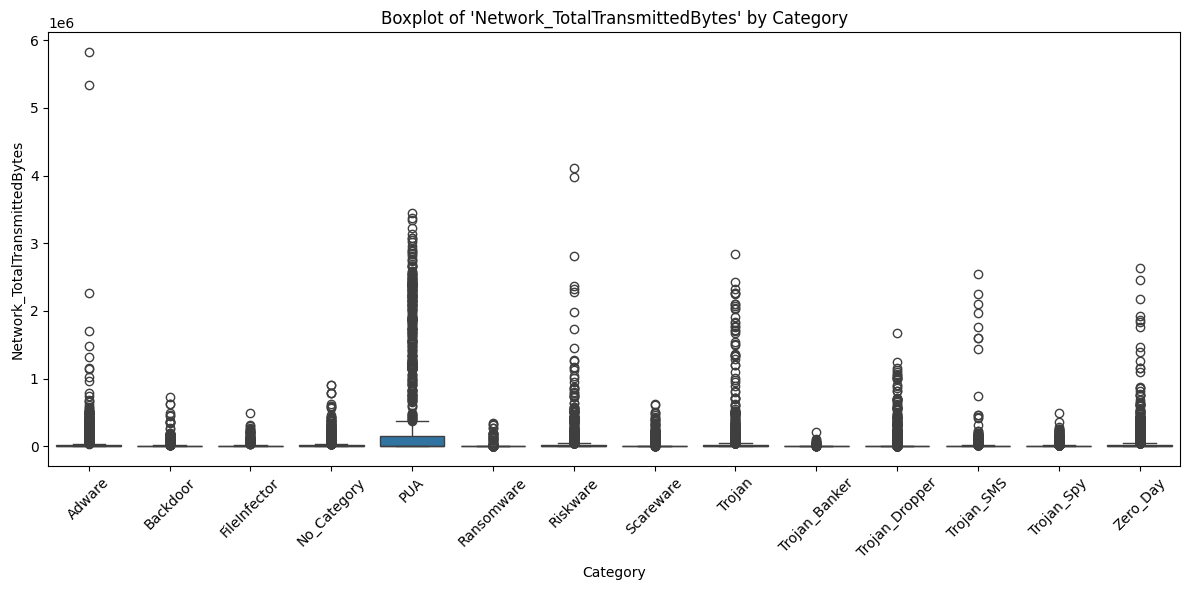

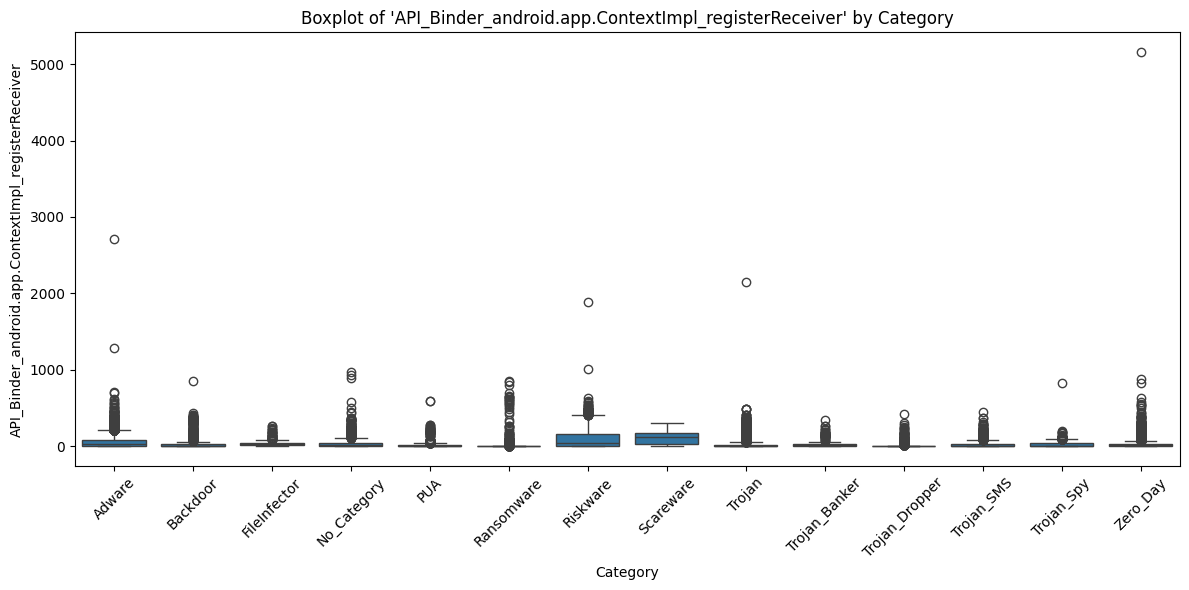

In [ ]:
# Select top 10 features by F-score (make sure anova_results is available)
top_10_features = anova_results.sort_values("F_score", ascending=False).head(10)["Feature"].tolist()

# Plot boxplots for each feature
for feature in top_10_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="Category", y=feature)
    plt.title(f"Boxplot of '{feature}' by Category")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Malware behavior is inherently variable. However, due to the heavy right-skew in many features, log transformation should likely be applied to normalize the range and reduce the impact of extreme values while still preserving the underlying pattern.


Additionally, models robust to outliers should be considered if these are kept.

##Category Distribution

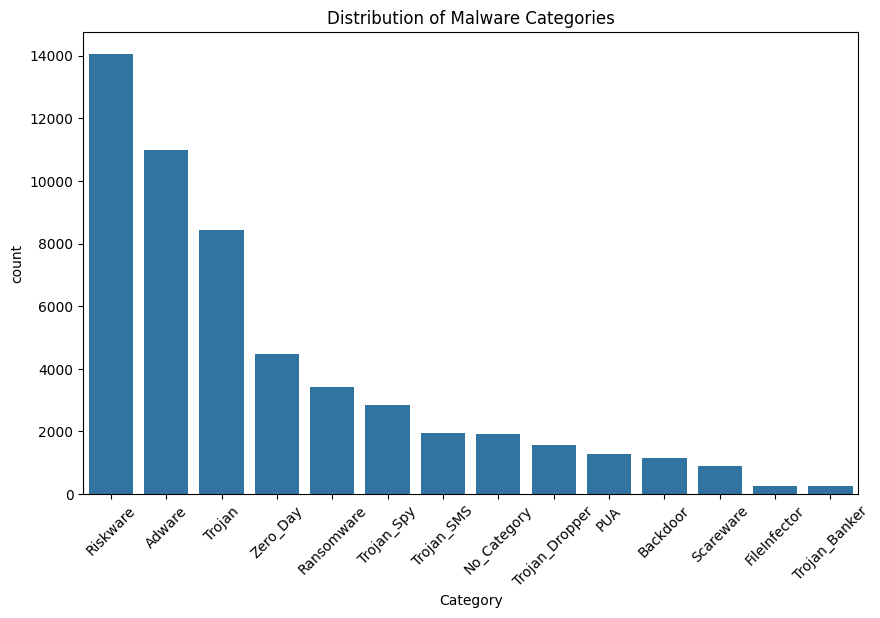

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="Category", order=df["Category"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Malware Categories")
plt.show()

The malware category distribution in the dataset is highly imbalanced, with a few classes (like Riskware, Adware, and Trojan) dominating the majority of samples.

This can lead to a situation where a classifier becomes biased toward the majority classes, achieving high overall accuracy but failing to correctly identify underrepresented malware types such as Trojan_Banker or FileInfector.

To address this, stratified sampling should be applied when splitting the dataset to preserve class proportions. During model training, techniques such as class weighting, SMOTE (Synthetic Minority Over-sampling Technique), ADASYN (Adaptive Synthetic Sampling), or under-sampling to balance the classes should be considered.

##Family

In [ ]:
#How many categories each family belongs to
df.groupby("Family")["Category"].nunique().sort_values(ascending=False)

Family
<unknown>                                     13
SINGLETON:c6ef57e2fcdb6e91ab644f2457290aaa     1
SINGLETON:c6f985d70c1d48ddbbaec022307cea30     1
SINGLETON:c7148e2031c52963b90c1467e63f648e     1
SINGLETON:c72d206bab845abf3df0000f8b1340b1     1
                                              ..
SINGLETON:67e4fcd0d451c14289ab23ebc5539e67     1
SINGLETON:67efeb3118b4df3f543bc9a0ad3d4185     1
SINGLETON:67f5372b75d0c7f5ba7f3568075e9d12     1
SINGLETON:67fb7c4e2211588ffe7fee58815ef174     1
SINGLETON:6703bc3b4d6878935e0146df3d2deb20     1
Name: Category, Length: 3078, dtype: int64

Almost every family is either unknown or unique



In [ ]:
multi_cat_families = family_to_category[family_to_category > 1]
print(f"Number of families mapping to multiple categories: {len(multi_cat_families)}")
print(multi_cat_families)

Number of families mapping to multiple categories: 1
Family
<unknown>    13
Name: Category, dtype: int64


There is only one Family that maps to multiple categories, and is the placeholder unknown.

The following code displays how many samples with unknown family labels belong to each malware category.



In [ ]:
df[df["Family"] == "<unknown>"]["Category"].value_counts()

Category
Riskware          597
Trojan            418
Zero_Day          176
Ransomware        137
Trojan_Spy        130
Trojan_SMS         81
No_Category        66
Trojan_Dropper     56
Backdoor           52
PUA                45
Scareware          37
FileInfector       17
Trojan_Banker       5
Name: count, dtype: int64

In [13]:
# Step 1: Count unique families per category
family_amount = df.groupby("Category")["Family"].nunique()

# Step 2: Total number of instances per category
total_per_category = df["Category"].value_counts()

# Step 3: Count how many of those are <unknown> per category
unknown_amount = df[df["Family"] == "<unknown>"]["Category"].value_counts()

# Step 4: Combine all stats into a summary table
summary_df = pd.DataFrame({
    "Family_amount": family_amount,
    "Total_category": total_per_category,
    "Unknown_amount": unknown_amount
}).fillna(0).astype({"Unknown_amount": int})

# Step 5: Calculate percentage of unknowns per category
summary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)

# Reorder columns for readability
summary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]

# Display the summary
print(summary_df)


                Family_amount  Total_category  Unknown_amount  %_Unknown
Category                                                                
Adware                     43           10980               0       0.00
Backdoor                   11            1137              52       4.57
FileInfector                5             248              17       6.85
No_Category               335            1932              66       3.42
PUA                         9            1290              45       3.49
Ransomware                  8            3411             137       4.02
Riskware                   19           14053             597       4.25
Scareware                   4             886              37       4.18
Trojan                     38            8437             418       4.95
Trojan_Banker              11             241               5       2.07
Trojan_Dropper             10            1570              56       3.57
Trojan_SMS                 10            1939      

In [ ]:
unknown_count = (df["Family"] == "<unknown>").sum()
print(f"Number of rows with Family == '<unknown>': {unknown_count}")


Number of rows with Family == '<unknown>': 1817


Based on the analysis of family distribution across categories:

The Adware category stands out with zero instances labeled as <unknown> and a balanced distribution across 43 families. This makes it a strong candidate for modeling.

In contrast, Zero_Day and No_Category The categories Zero_Day and No_Category exhibit extremely high family dispersion, with 2576 and 335 unique families. These values are significantly higher than all other categories, which generally have fewer than 50 families each.


This suggests they function more as placeholder labels. In particular, Zero_Day likely serves as a catch-all label for unknown or uncategorized threats, making it ambiguous. In cybersecurity, this term is refered to a new unknown vulnerability, not yet classified in terms of malware behavior, this is why samples are varied. They do not seem to represent a consistent type. On the other hand, No_Category explicitly denotes a lack of category. So, including these instances would only bring noise to the training process, preventing the model from learning meaningful patterns.
Therefore, they are excluded from the final dataset to preserve the quality and consistency of the classification task.


Additionally, categories like FileInfector show a high percentage of <unknown> families (6.85%) despite having a small total count, raising concerns about label quality. Most other categories maintain a relatively stable level of unknowns (around 3–5%), indicating that the presence of <unknown> is manageable.


In [ ]:
#BASED ON OTHER PAPERS
# Exclude instances where Category is Zero_Day or No_Category
df = df[~df["Category"].isin(["Zero_Day", "No_Category"])]

# 2. Exclude instances where Family is <unknown>
df = df[df["Family"] != "<unknown>"]

# 3. Exclude families with ≤ 9 instances
family_counts = df["Family"].value_counts()
valid_families = family_counts[family_counts > 9].index
df = df[df["Family"].isin(valid_families)]

# 4. Drop columns where all values are 0
df = df.loc[:, (df != 0).any(axis=0)]

# Check final shape
print(f"Filtered dataset shape: {df.shape}")


Filtered dataset shape: (45299, 123)


In [ ]:
df.shape

(45299, 123)

##Correlation Heatmap

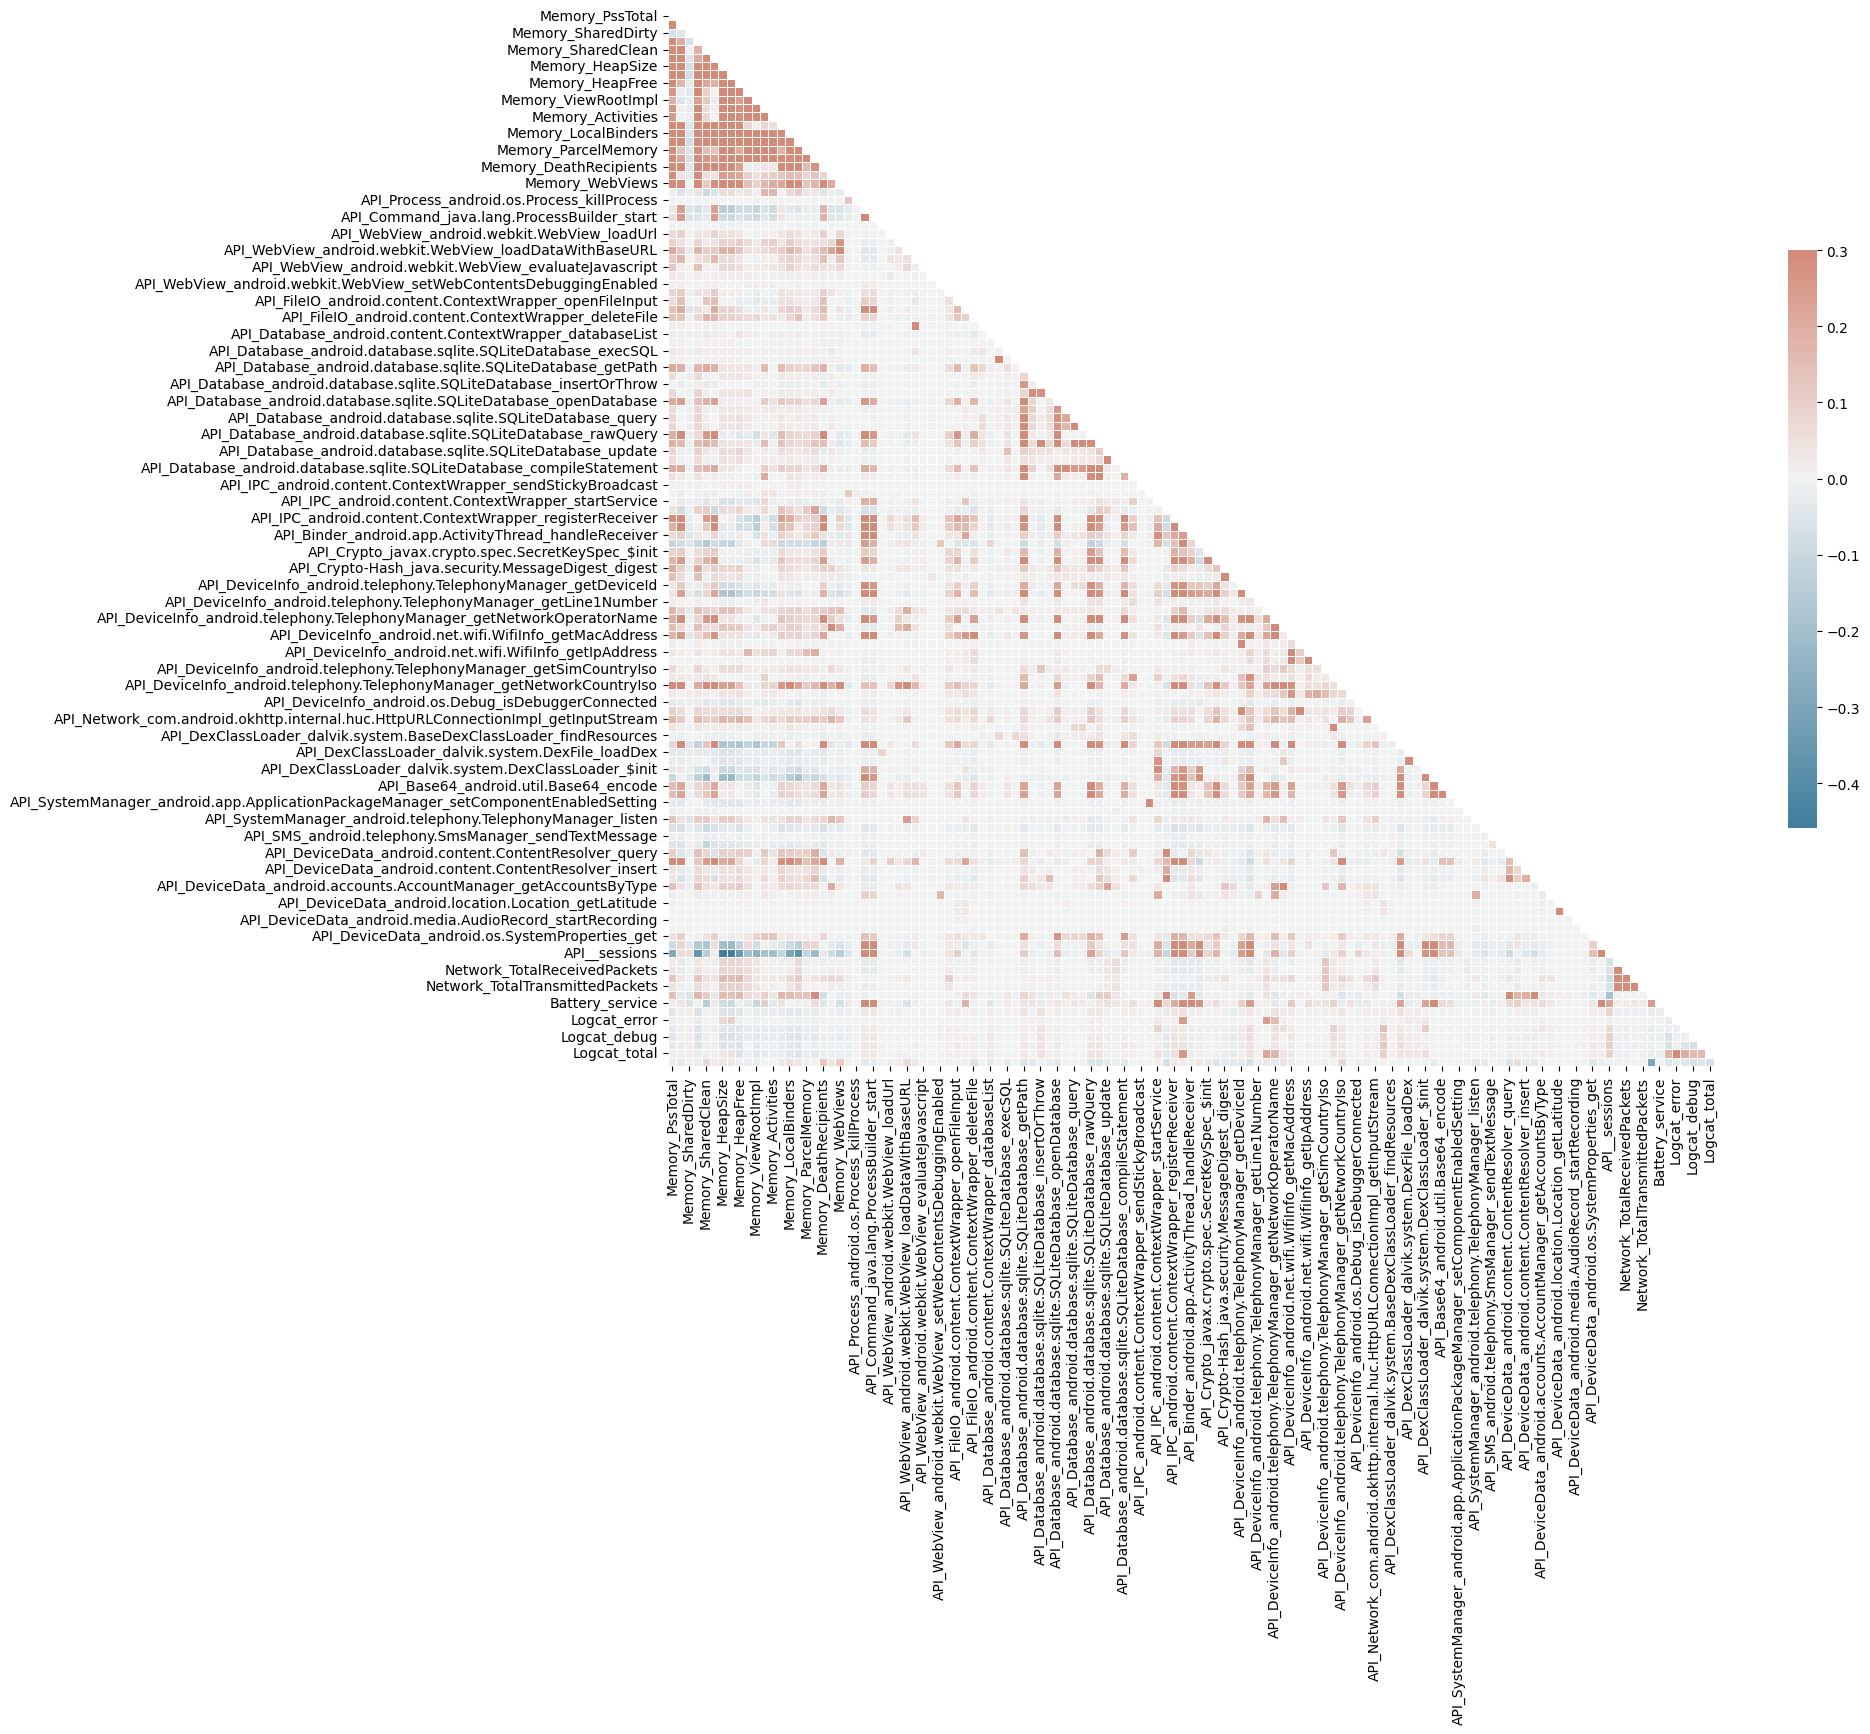

In [54]:
only_numeric = df.drop(columns=["Category", "Family", "reboot"])

def compute_correlation_matrix(figsize, dataframe):
  # Compute the correlation matrix
  corr = dataframe.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=figsize)
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

compute_correlation_matrix((17, 15), only_numeric)

We can see that there is a slight correlation between variables because the predominant color is grey.

The "Memory" group of variables is the one with more correlation among variables of the same group.

Moreover we can clearly see variables that have 0 correlation with all other variables, and that's why we can see totally white strips.

Variable: Memory

In [55]:
features_memory = ["PssTotal", "PssClean", "SharedDirty", "PrivateDirty",
                   "SharedClean", "PrivateClean", "HeapSize",
                   "HeapAlloc", "HeapFree", "Views", "ViewRootImpl",
                   "AppContexts", "Activities", "Assets", "LocalBinders",
                   "ProxyBinders", "ParcelMemory", "ParcelCount",
                   "DeathRecipients", "OpenSSLSockets", "WebViews"]
features_memory = ["Memory_" + feat for feat in features_memory]
only_numeric.loc[:, features_memory].describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     53439.000000     53439.000000        53439.000000   
mean      70918.399034     12742.597429        10855.112259   
std       36366.690217     12894.559046         2144.360998   
min        4506.000000         0.000000         7036.000000   
25%       46165.000000      3968.000000        10540.000000   
50%       61284.000000      6340.000000        10728.000000   
75%       91740.000000     20048.000000        11144.000000   
max      829169.000000    106360.000000       446548.000000   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         53439.000000        53439.000000         53439.000000   
mean          47633.930650        87981.107506         14316.579801   
std           29898.257374        15859.495550         13463.546087   
min              12.000000         4268.000000             0.000000   
25%           31968.000000        76642.000000          4980.000000   
50%           41432.000000        89536.000000          8176.000000   
75%           55358.000000        99052.000000         21748.000000   
max          826672.000000       183600.000000        110336.000000   

       Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  Memory_Views  ...  \
count     53439.000000      53439.000000     53439.000000  53439.000000  ...   
mean      22279.227231      17541.766163      4736.468759     89.038418  ...   
std       12502.584219      10458.311683      2920.007863    247.553043  ...   
min        5113.000000       3249.000000       983.000000      0.000000  ...   
25%       13486.500000      10669.500000      2993.000000      9.000000  ...   
50%       20468.000000      16575.000000      4068.000000     35.000000  ...   
75%       28735.500000      22840.000000      5845.000000    116.000000  ...   
max      310155.000000     286959.000000     88630.000000  29850.000000  ...   

       Memory_AppContexts  Memory_Activities  Memory_Assets  \
count        53439.000000       53439.000000   53439.000000   
mean             6.191265           2.266547       2.926664   
std              5.291457           4.652599       1.857883   
min              0.000000           0.000000       1.000000   
25%              4.000000           1.000000       2.000000   
50%              6.000000           2.000000       2.000000   
75%              7.000000           3.000000       4.000000   
max            451.000000         446.000000     122.000000   

       Memory_LocalBinders  Memory_ProxyBinders  Memory_ParcelMemory  \
count         53439.000000         53439.000000         53439.000000   
mean             20.422051            31.720391             9.277007   
std              18.587868             7.677878            14.612777   
min               1.000000            21.000000             1.000000   
25%              10.000000            27.000000             4.000000   
50%              17.000000            32.000000             7.000000   
75%              30.000000            36.000000            12.000000   
max            1931.000000           531.000000          1695.000000   

       Memory_ParcelCount  Memory_DeathRecipients  Memory_OpenSSLSockets  \
count        53439.000000            53439.000000           53439.000000   
mean            30.765883                0.877861               0.293643   
std             33.224723                1.408909               1.922096   
min              6.000000                0.000000               0.000000   
25%             15.000000                0.000000               0.000000   
50%             25.000000                0.000000               0.000000   
75%             41.000000                2.000000               0.000000   
max           4311.000000               11.000000              92.000000   

       Memory_WebViews  
count     53439.000000  
mean          0.722525  
std           2.388952  
min           0.000000  
25%           0.000000  
50%           0.000000  
7

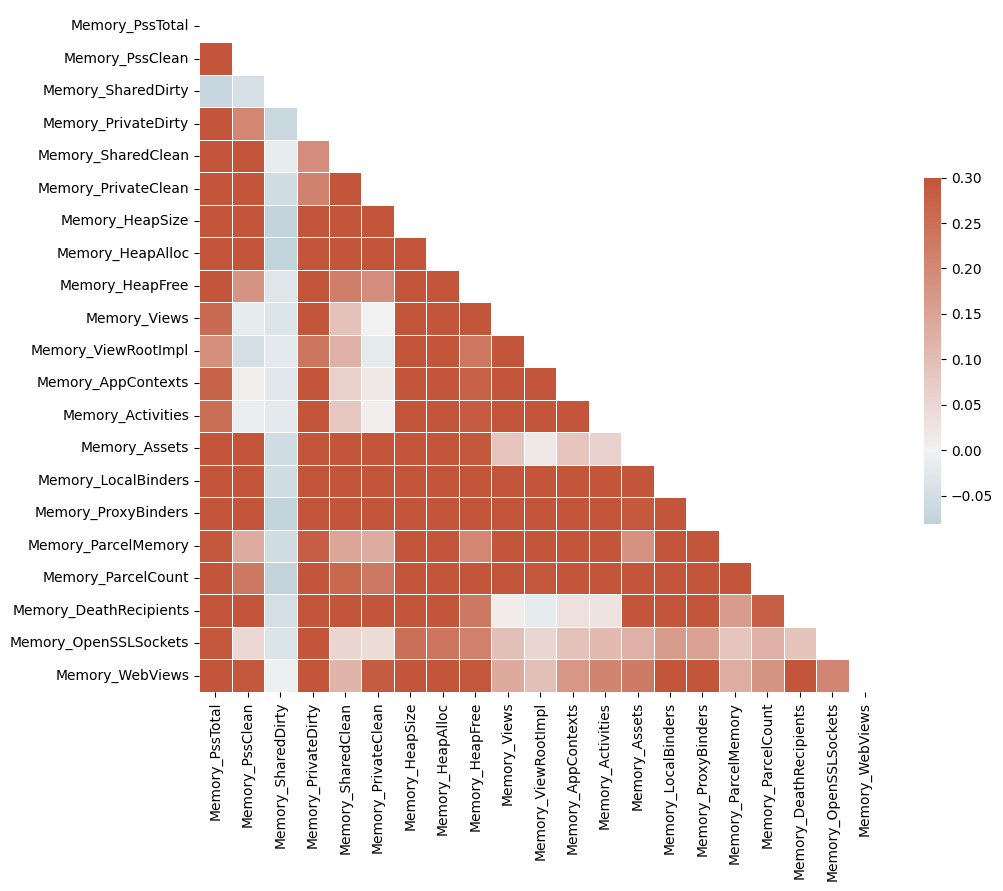

In [56]:
# Compute the correlation matrix
compute_correlation_matrix((11, 9), only_numeric.loc[:, features_memory])

In [64]:
 #Finding highly correlated features
 # Select only numerical columns
numerical_df = df.select_dtypes(include=[np.number])

# Compute the absolute correlation matrix for numerical columns
correlation_matrix = numerical_df.corr().abs()

# Select the upper triangle of the correlation matrix (to avoid duplicated values)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.85
high_correlation = [column for column in upper.columns if any(upper[column] > 0.85)]

print("Highly correlated features:\n", high_correlation)

Highly correlated features:
 ['Memory_PrivateDirty', 'Memory_PrivateClean', 'Memory_HeapAlloc', 'Memory_Activities', 'API_Command_java.lang.ProcessBuilder_start', 'API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase', 'API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory', 'API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory', 'API_Database_android.database.sqlite.SQLiteDatabase_compileStatement', 'API_Binder_android.app.ContextImpl_registerReceiver', 'API_DeviceInfo_android.net.wifi.WifiInfo_getNetworkId', 'API_Base64_android.util.Base64_encodeToString', 'API_SystemManager_android.app.ApplicationPackageManager_setComponentEnabledSetting', 'API_DeviceData_android.location.Location_getLongitude', 'Network_TotalReceivedPackets', 'Network_TotalTransmittedBytes', 'Network_TotalTransmittedPackets', 'Logcat_total']


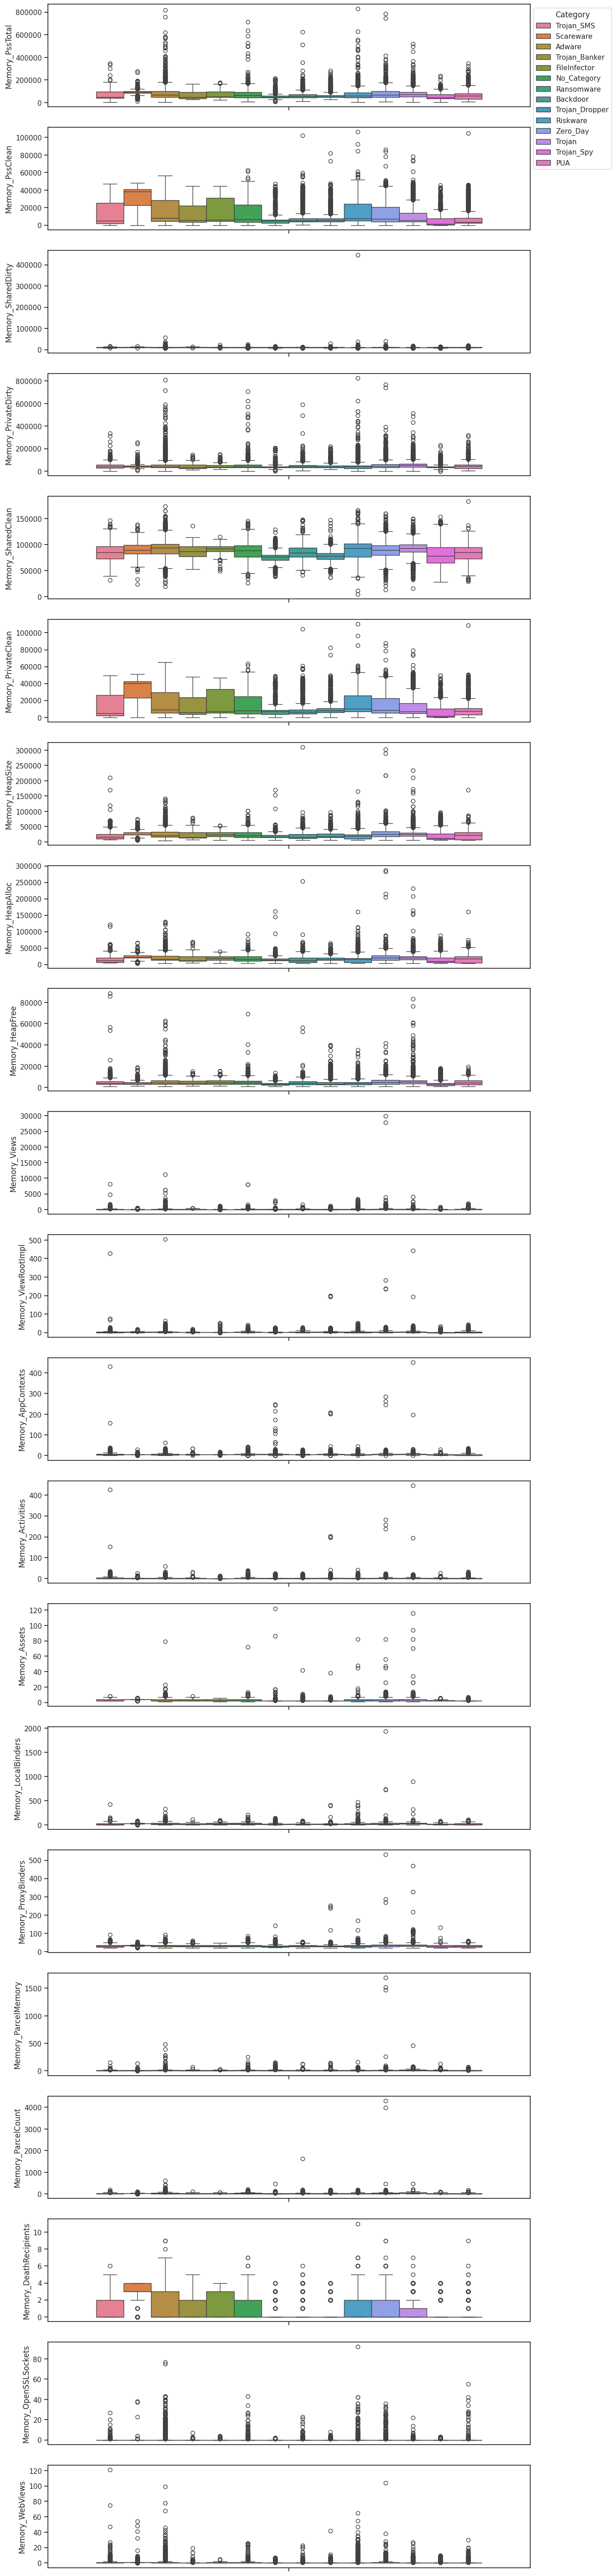

In [57]:
def box_plot_features(features):
  sns.set_theme(style="ticks", palette="pastel")
  fig = plt.figure(figsize=(30, 80))
  legend = True
  for idx, feat in enumerate(features):
    if idx != 0:
      legend = False
    ax = fig.add_subplot(23, 2, idx*2+1)
    sns.boxplot(y=feat, hue="Category",
                data=df, ax=ax, legend=legend)
    if legend:
      sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
  plt.show();


box_plot_features(features_memory)

Outliers are observed in all the diagrams and all the characteristics of this group, this makes some graphs very flat. In Memory_DeathRecipients some categories seem to have very low values compared to the others which may help to distinguish them.

Variable: Network

In [58]:
features_network = ["TotalReceivedBytes", "TotalReceivedPackets",
                    "TotalTransmittedBytes", "TotalTransmittedPackets"]
features_network = ["Network_" + feat for feat in features_network]
df.loc[:, features_network].describe()

Network_TotalReceivedBytes  Network_TotalReceivedPackets  \
count                5.343900e+04                  53439.000000   
mean                 1.036051e+06                    800.677782   
std                  1.065564e+07                   7542.013814   
min                  0.000000e+00                      0.000000   
25%                  0.000000e+00                      0.000000   
50%                  1.278000e+03                     11.000000   
75%                  1.212400e+04                     71.000000   
max                  2.320056e+08                 166574.000000   

       Network_TotalTransmittedBytes  Network_TotalTransmittedPackets  
count                   5.343900e+04                     53439.000000  
mean                    3.136361e+04                       465.827617  
std                     1.626149e+05                      3635.819566  
min                     0.000000e+00                         0.000000  
25%                     0.000000e+00                         0.000000  
50%                     3.429000e+03                        20.000000  
75%                     1.626300e+04                       123.000000  
max                     5.826047e+06                     85873.000000

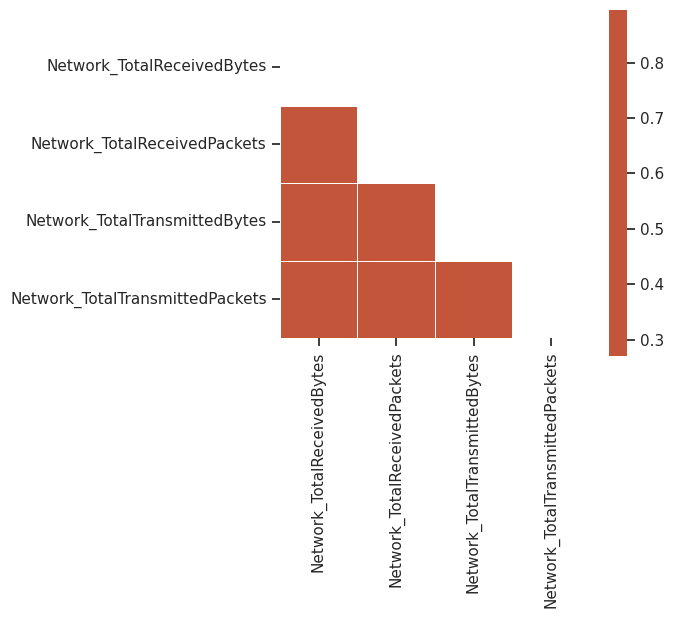

In [59]:
# Compute the correlation matrix
compute_correlation_matrix((5, 9), only_numeric.loc[:, features_network])

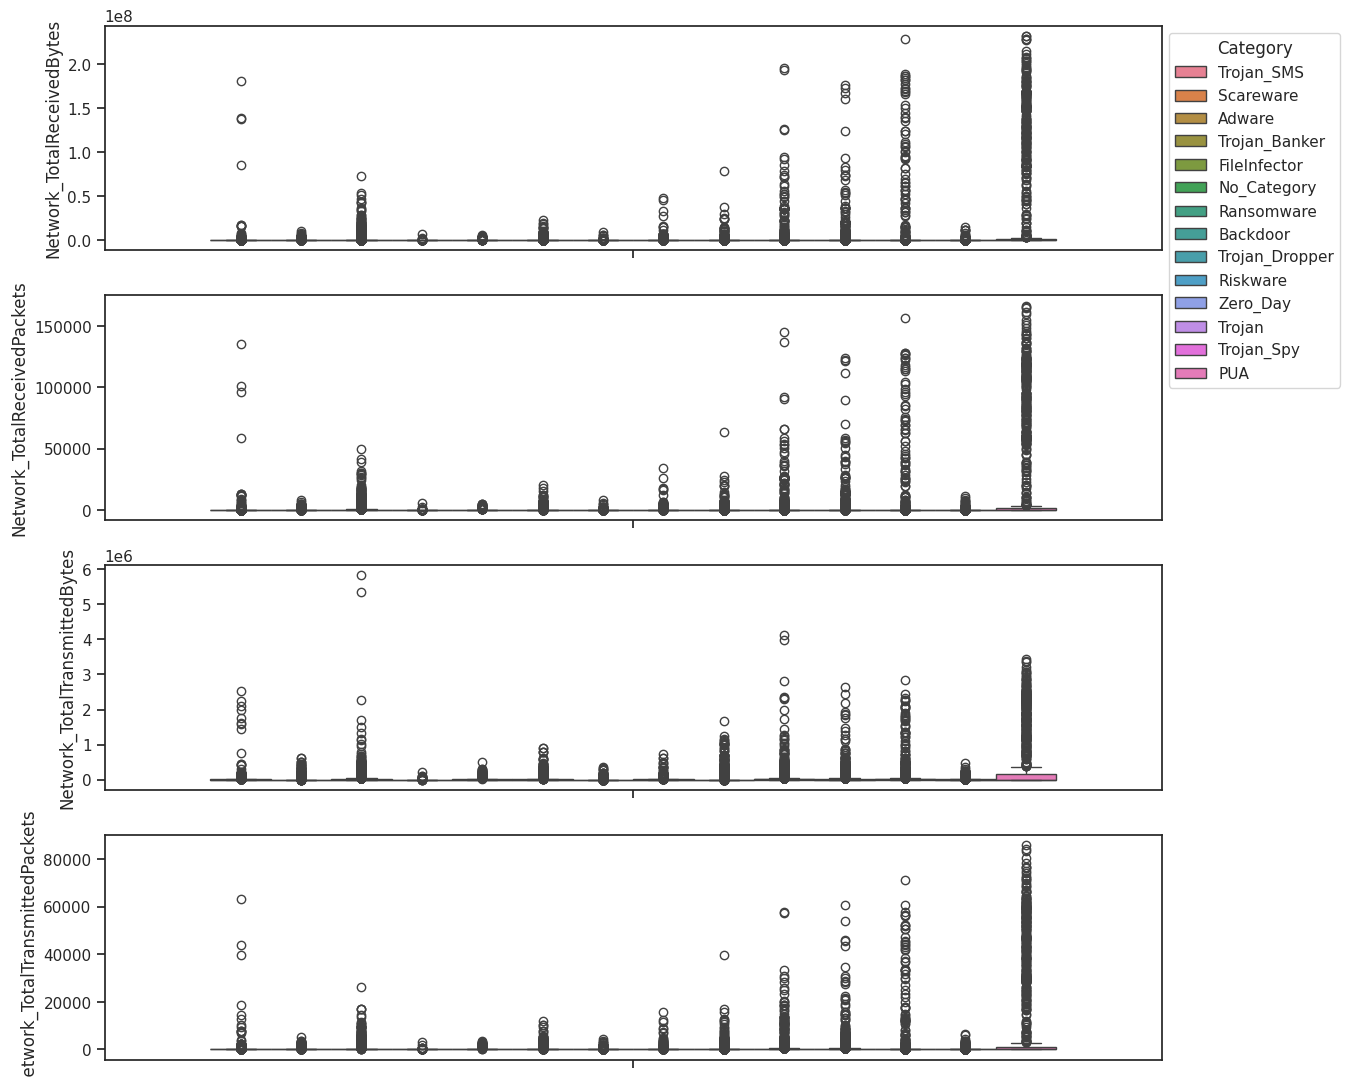

In [60]:
box_plot_features(features_network)

It is observed that although the graphs have different scales, they are quite similar to each other and do not provide much information to distinguish between categories.

Variable: Battery

In [61]:
features_battery  = ["wakelock", "service"]
features_battery = ["Battery_" + feat for feat in features_battery]
only_numeric.loc[:, features_battery].describe()

Battery_wakelock  Battery_service
count      53439.000000     53439.000000
mean           3.397332         0.721215
std            1.520636         0.981305
min            0.000000         0.000000
25%            2.000000         0.000000
50%            3.000000         0.000000
75%            4.000000         1.000000
max           18.000000        10.000000

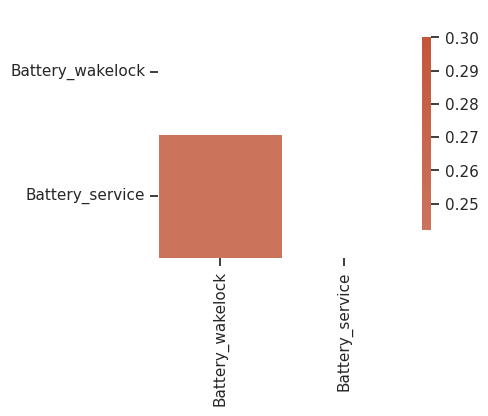

In [62]:
# Compute the correlation matrix
compute_correlation_matrix((4,5), only_numeric.loc[:, features_battery])

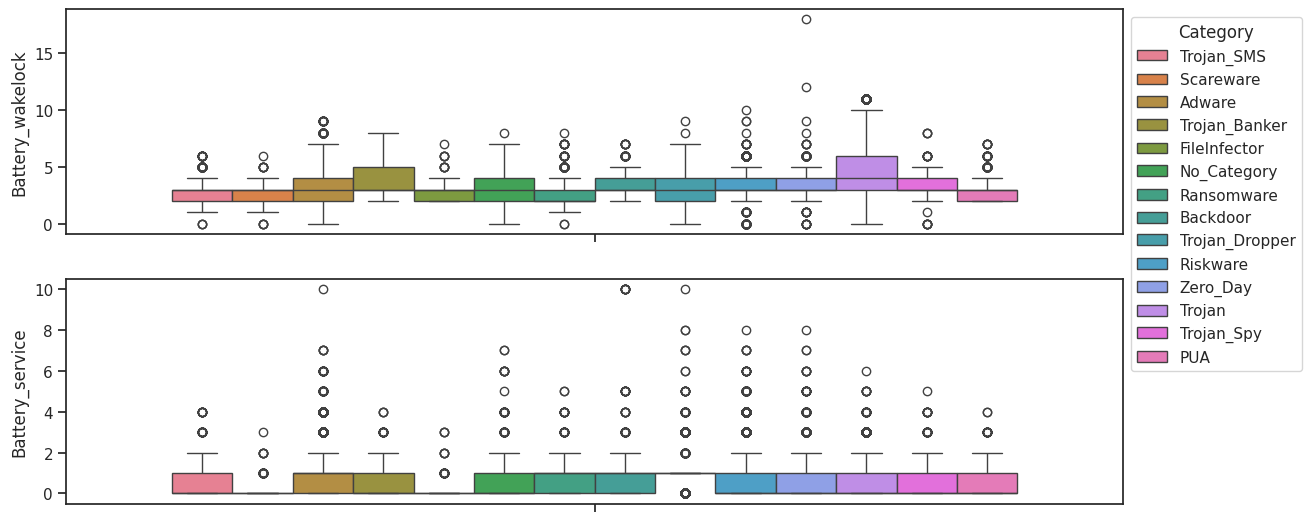

In [63]:
box_plot_features(features_battery)

Baterry service has graphs showing biases to the right and for the categories FileInfector, Trojan Dropper and Scareware flat boxes.

Variables: locat and process

In [65]:
features_logcat = ["total","verbose", "debug", "info", "warning", "error"]
features_process = ["total"]
features_logcat = ["Logcat_" + feat for feat in features_logcat]
features_process = ["Process_total"]
only_numeric.loc[:, features_logcat + features_process].describe()

Logcat_total  Logcat_verbose  Logcat_debug    Logcat_info  \
count  5.343900e+04    53439.000000  53439.000000   53439.000000   
mean   1.159461e+04     2297.199629   2299.034825    2342.177717   
std    1.011978e+04     1971.010444   2053.110481    2273.059991   
min    3.121000e+03       33.000000     40.000000       6.000000   
25%    9.417000e+03     1137.000000   1099.000000    1155.000000   
50%    1.097700e+04     2007.000000   2014.000000    2040.000000   
75%    1.298300e+04     3033.000000   3024.000000    3054.000000   
max    2.067038e+06   102860.000000  89456.000000  219143.000000   

       Logcat_warning  Logcat_error  Process_total  
count    53439.000000  5.343900e+04   53439.000000  
mean      2298.847845  2.357353e+03     190.167181  
std       2271.006005  9.360781e+03       2.902841  
min         36.000000  4.000000e+01     172.000000  
25%       1108.000000  1.098000e+03     188.000000  
50%       2006.000000  2.021000e+03     190.000000  
75%       3028.000000  3.029000e+03     192.000000  
max     142420.000000  2.066046e+06     226.000000

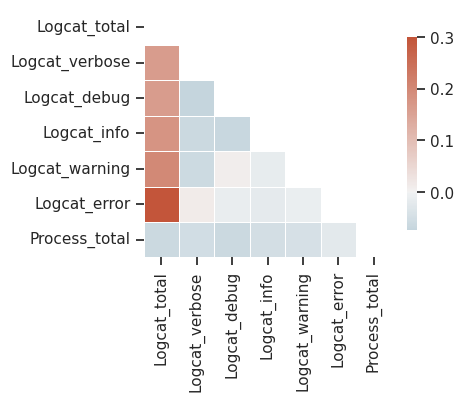

In [66]:
# Compute the correlation matrix
compute_correlation_matrix((4,5), only_numeric.loc[:, features_logcat + features_process])

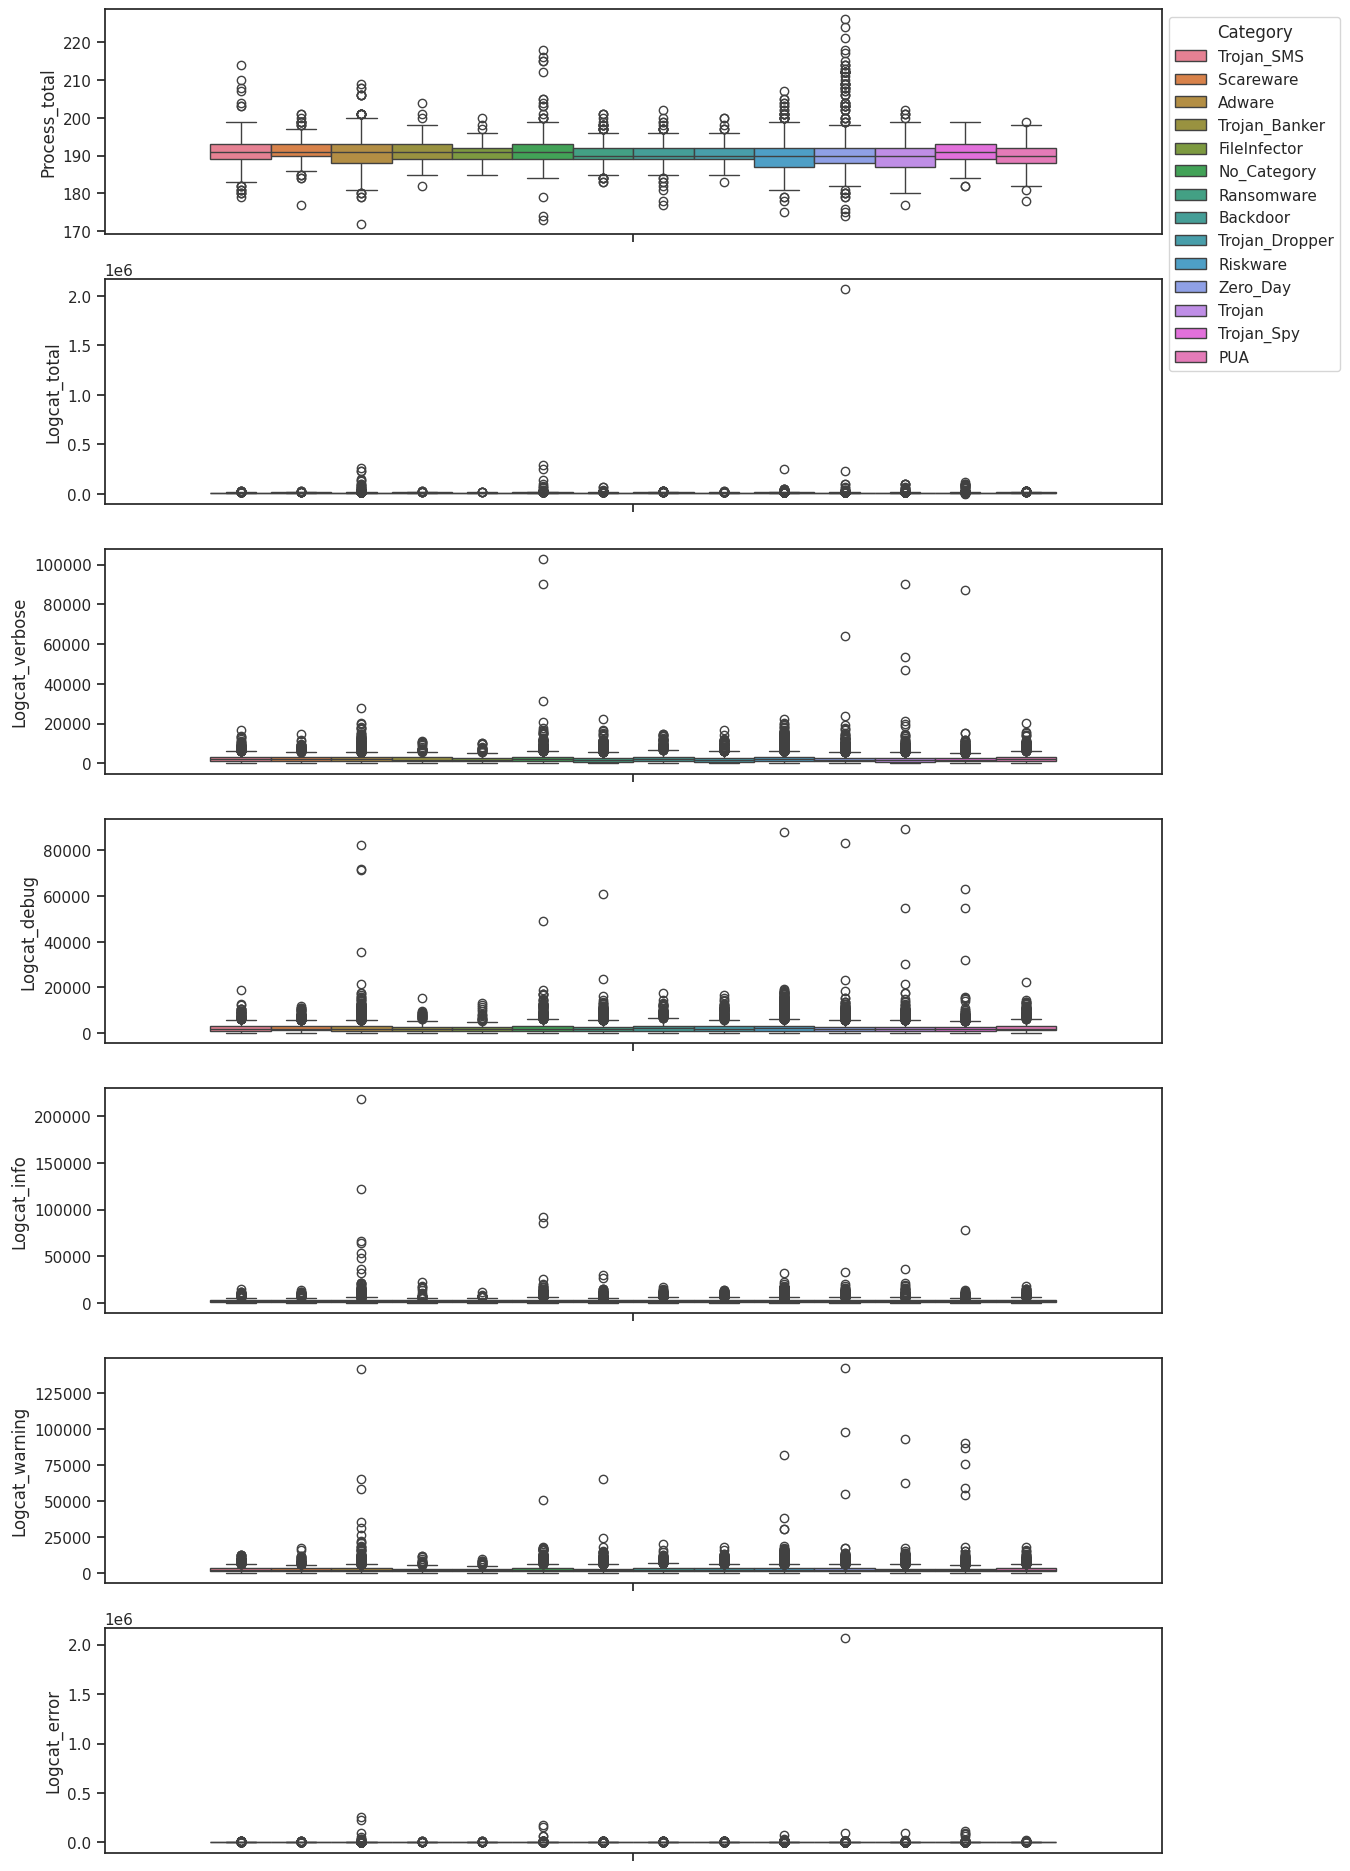

In [67]:
box_plot_features(features_process + features_logcat)

The logcat graphs are similar and the process graphs are similar between the different categories.

Variable: API

1. Base64_android

In [68]:
API_features = [feat for feat in set(only_numeric) - set(zero_columns)
                if feat.startswith("API_")]
short_names_API = {feat:feat.split(".")[-1] for feat in API_features}
# realizamos un cambio del nombre de variables para que no afecte tanto
# la visualizacion
df = df.rename(columns=short_names_API)
only_numeric = only_numeric.rename(columns=short_names_API)

NameError: name 'zero_columns' is not defined

In [ ]:
features_base64 = ['Base64_decode', 'Base64_encode', 'Base64_encodeToString']
sns.pairplot(df.loc[:, features_base64 + ['Category']], hue="Category");

# FEATURE ANALYSIS

- Feature transformation
- Feature engineering
- Feature selection


### QUESTIONS
- How does feature hashing relate here?
- How can PCA be useful here?

## FEATURE TRANSFORMATION

- Binning
- Log transformation
- Interaction terms

## FEATURE ENGINEERING
- Domain-specific features
- Interactions effects

## FEATURE SELECTION
- Analyze correlation and low-variances
- Remove low-predictive power variables

# MODEL SELECTION

In this section we will train, optimize hpyerparmeter and assess 5 classifiers:
- Logistic regression
- Decistion trees
- Random forest
- Gradient boosted machines